plots on geocoronal Ha
LVM sky subtraction busyweek, Dec 2024
Kathryn Kreckel

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits, ascii

from astropy.wcs import wcs
from astropy.table import Table

from scipy.ndimage import median_filter
from astropy.modeling import models, fitting


from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
from astropy.time import Time


import matplotlib as mpl
import pickle

from astropy.table import QTable
from astropy import table

import glob
import os
import datetime 
import scipy 

import astral
from astropy.time import Time, TimezoneInfo
from astropy.coordinates import AltAz, EarthLocation, get_sun
from astral.sun import sun
from datetime import date, time, timezone

from shadow_height_lib import shadow_calc

In [2]:
font = {'size'   : 18}

mpl.rc('font', **font)

In [3]:
def forward(x):
    return x / 5.661e-18 # returns Rayleigh

def inverse(x):
    return x * 5.661e-18 # returns erg/s/cm^2/arcsec^2

Full fitting code is not shown, but available upon request. Resulting fits are compiled in the following fits file:


In [4]:
t = table.Table.read('v1.1.0/saved_dictionary_geocoronal_v4.fits')  
drpall = table.Table.read('/data/LVM/sdsswork/lvm/spectro/redux/1.1.0/drpall-1.1.0.fits')

t.sort('frame')

In [54]:
# shadow height in the drpall file seems to be incorrect, 
# this code  fixes it but takes a little bit of time to run

if False:
    from shadow_height_lib import shadow_calc

    # initialize the shadow height calculation
    s=shadow_calc()

    for dd in drpall:
        time = Time(dd['obstime'],format='isot', scale='utc')
        jj = time.jd

        cc = SkyCoord(dd['skye_ra'],dd['skye_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['skye_sh_hght'] = s.get_heights(return_heights=True, unit="km")

        cc = SkyCoord(dd['skyw_ra'],dd['skyw_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['skyw_sh_hght'] = s.get_heights(return_heights=True, unit="km")

        cc = SkyCoord(dd['sci_ra'],dd['sci_dec'],frame='icrs',unit=u.deg)
        s.set_coordinates(cc.ra.deg,cc.dec.deg)
        s.update_time(jd=jj)
        dd['sci_sh_hght'] = s.get_heights(return_heights=True, unit="km")

    #for tt in t:


/home/kkreckel/SDSSV/sky_subtraction/shadow_height_lib.py:172: RuntimeWarning: All-NaN axis encountered
  self.dist[positive_delta] = np.nanmin([dist_b1[positive_delta], dist_b2[positive_delta]], axis=0)


**Columns in the astropy table based on the geocoronal line fits:**

* 'frame': exposure number
* 'mjd': MJD
* 'wham': name of the WHAM dark field
* 'center': geocoronal ha line centroid (A)
* 'flux': geocoronal ha line flux (erg/s/cm^2/arcsec^2)
* 'flux_err': geocoronal ha line flux (erg/s/cm^2/arcsec^2)
* 'stddev': geocoronal ha line broadening
* 'center6533': OH 6533 line centroid (A)
* 'flux6533': OH 6553 line flux (erg/s/cm^2/arcsec^2)
* 'center6554': OH 6554 line centroid (A)
* 'flux6554': OH 6554 line flux (erg/s/cm^2/arcsec^2)
* 'am': airmass
* 'hz': shadow height (km)
* 'filename': filename
* 'sky': which sky telescope
* 'baseline': median continuum level of sky spectrum (erg/s/cm^2/A/Fiber)
* 'rho': separation of Moon and object (deg)
* 'sun_alt': sun altitude (deg)
* 'time': time as astropy.time object
* 'solar_obsflux': Daily flux values are the radio emission from the Sun at a wavelength of 10.7 centimetres recorded daily (sfu = solar flux unit).
https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-en.php
https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-3-en.php

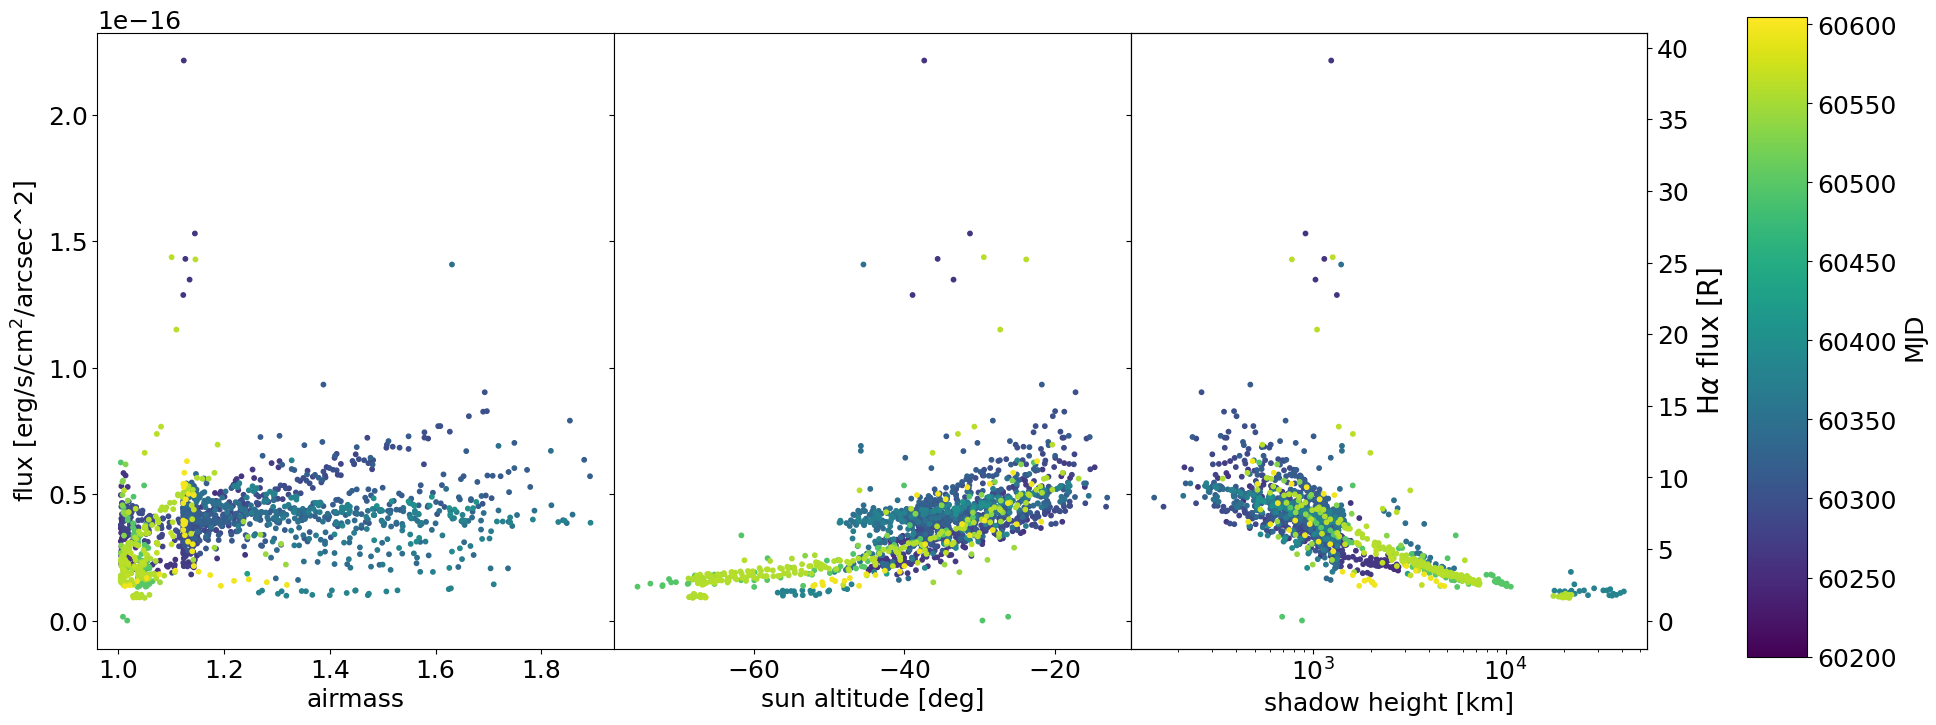

In [7]:
# Normalize the array vals so they can be mapped to a color
c_norm = mpl.colors.Normalize(vmin=60200, vmax=60605)

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8),sharey=True,gridspec_kw={'wspace':0})


axes[0].scatter(t['am'],t['flux'],s=10,color=s_map.to_rgba(t['mjd']))

axes[1].scatter(t['sun_alt'],t['flux'],s=10,color=s_map.to_rgba(t['mjd']))

axes[2].scatter(t['hz'],t['flux'],s=10,color=s_map.to_rgba(t['mjd']))


axes[0].set_ylabel(r'flux [erg/s/cm$^2$/arcsec^2]')

ax2 = axes[2].twinx()
lim1,lim2 = axes[1].get_ylim()
ax2.set_ylim(forward(lim1),forward(lim2))
ax2.set_ylabel(r'H$\alpha$ flux [R]',size=20)

axes[0].set_xlabel('airmass')
axes[1].set_xlabel('sun altitude [deg]')
axes[2].set_xlabel('shadow height [km]')

axes[2].set_xscale('log')

# add color bars
cbaxes = fig.add_axes([0.95, 0.10, 0.03, 0.8]) 
cb = plt.colorbar(s_map,cax = cbaxes,orientation='vertical')#,ticks=[0,1.0,2.0,3.0,4.0]) 
cb.set_label('MJD')

fig.savefig('v1.1.0/geocoronal_all.png')

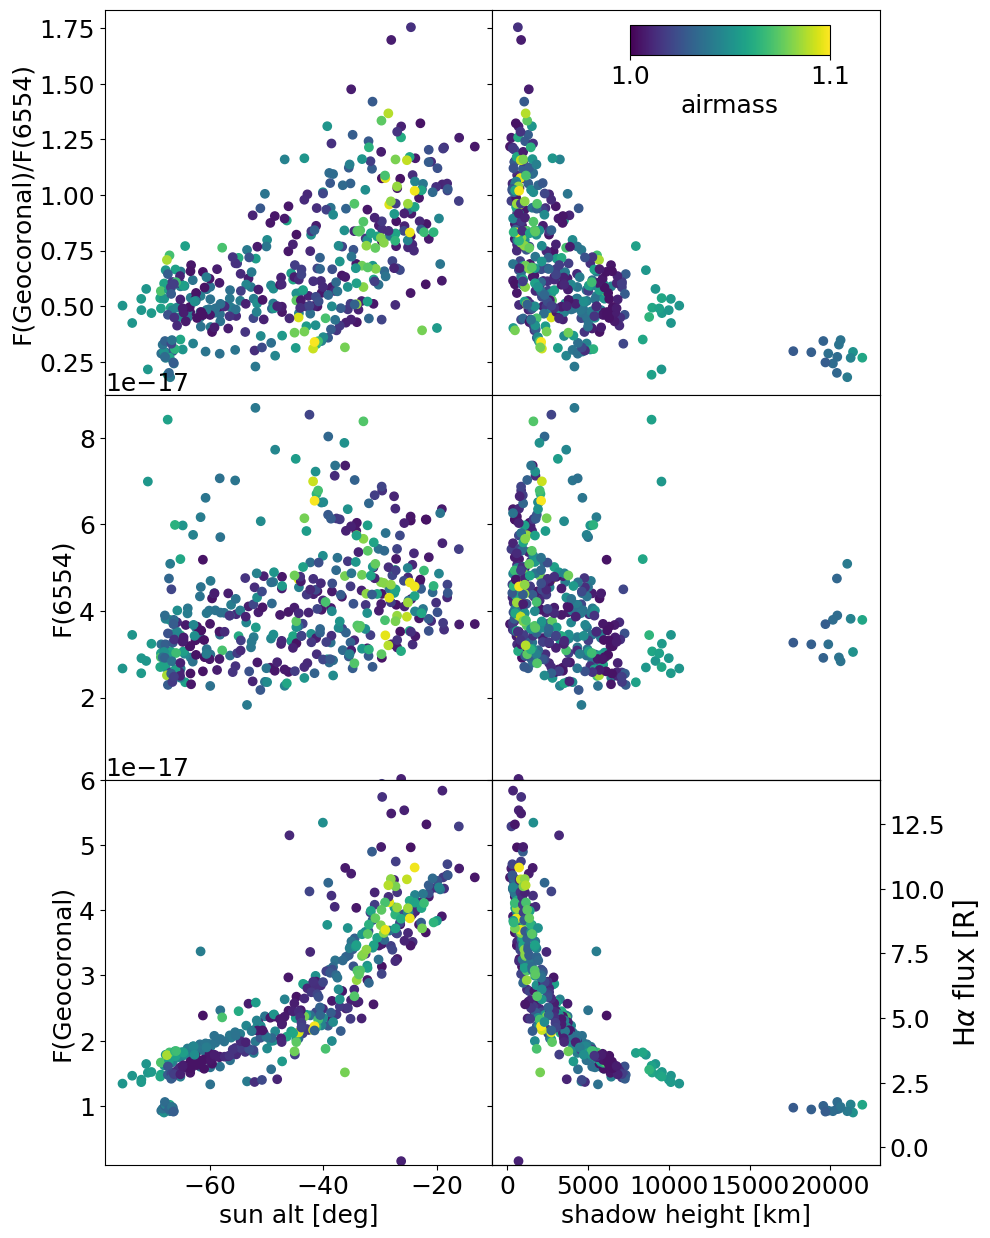

In [8]:
# Normalize the array vals so they can be mapped to a color
c_norm = mpl.colors.Normalize(vmin=1.0, vmax=1.1)
#c_norm = mpl.colors.Normalize(vmin=-90, vmax=-20)

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


sub = (t['am'] < 1.1)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15), gridspec_kw={'hspace': 0, 'wspace': 0},
                         sharex=False,sharey=False)

axes[0,0].scatter(t['sun_alt'][sub],t['flux'][sub]/t['flux6554'][sub],color=s_map.to_rgba(t['am'][sub]))
axes[0,0].set_ylabel(r'F(Geocoronal)/F(6554)')
axes[0,0].set_xlabel(r'sun alt [deg]')
#plt.gca().invert_xaxis()

axes[0,1].set_yticklabels([])
axes[0,1].scatter(t['hz'][sub],t['flux'][sub]/t['flux6554'][sub],color=s_map.to_rgba(t['am'][sub]))
axes[0,1].set_xlabel(r'shadow height [km]')


axes[2,0].scatter(t['sun_alt'][sub],t['flux'][sub],color=s_map.to_rgba(t['am'][sub]))
axes[2,0].set_ylabel(r'F(Geocoronal)')
axes[2,0].set_xlabel(r'sun alt [deg]')
#plt.gca().invert_xaxis()

axes[2,1].set_yticklabels([])
axes[2,1].scatter(t['hz'][sub],t['flux'][sub],color=s_map.to_rgba(t['am'][sub]))
axes[2,1].set_xlabel(r'shadow height [km]')

ax2 = axes[2,1].twinx()
lim1,lim2 = axes[2,1].get_ylim()
ax2.set_ylim(forward(lim1),forward(lim2))
ax2.set_ylabel(r'H$\alpha$ flux [R]',size=20)


axes[1,0].scatter(t['sun_alt'][sub],t['flux6554'][sub],color=s_map.to_rgba(t['am'][sub]))
axes[1,0].set_ylabel(r'F(6554)')
axes[1,0].set_xlabel(r'sun alt [deg]')
#plt.gca().invert_xaxis()

axes[1,1].set_yticklabels([])
axes[1,1].scatter(t['hz'][sub],t['flux6554'][sub],color=s_map.to_rgba(t['am'][sub]))
axes[1,1].set_xlabel(r'shadow height [km]')

#axes[1].set_xscale('log')
#axes[1].set_yscale('log')

axes[2,0].set_ylim(0.01e-16,.6e-16)
axes[2,1].set_ylim(0.01e-16,.6e-16)

axes[1,0].set_ylim(0.01e-16,.9e-16)
axes[1,1].set_ylim(0.01e-16,.9e-16)


if True:
    cbaxes = fig.add_axes([0.65, 0.85, 0.2, 0.02]) 
    cb = plt.colorbar(s_map,cax = cbaxes,orientation='horizontal')#,ticks=[500,2000, 4000]) 
    cb.set_label('airmass')
    #cb.set_label('sun altitude [deg]')


fig.savefig('v1.1.0/geocoronal_OH_sunalt_compare.png')

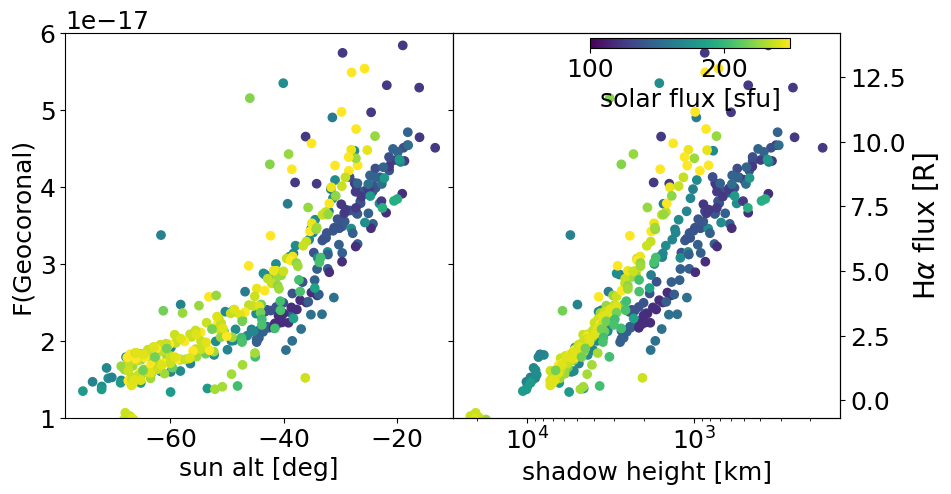

In [8]:
# Normalize the array vals so they can be mapped to a color
c_norm = mpl.colors.Normalize(vmin=100, vmax=250)
#c_norm = mpl.colors.Normalize(vmin=-90, vmax=-20)

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


sub = (t['am'] < 1.1)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), gridspec_kw={'hspace': 0, 'wspace': 0},
                         sharex=False,sharey=False)


axes[0].scatter(t['sun_alt'][sub],t['flux'][sub],color=s_map.to_rgba(t['solar_obsflux'][sub]))
axes[0].set_ylabel(r'F(Geocoronal)')
axes[0].set_xlabel(r'sun alt [deg]')
plt.gca().invert_xaxis()

axes[1].set_yticklabels([])
axes[1].scatter(t['hz'][sub],t['flux'][sub],color=s_map.to_rgba(t['solar_obsflux'][sub]))
axes[1].set_xlabel(r'shadow height [km]')

ax2 = axes[1].twinx()
lim1,lim2 = axes[1].get_ylim()
ax2.set_ylim(forward(lim1),forward(lim2))
ax2.set_ylabel(r'H$\alpha$ flux [R]',size=20)


axes[0].set_ylim(0.1e-16,.6e-16)
axes[1].set_ylim(0.1e-16,.6e-16)
axes[1].set_xscale('log')


if True:
    cbaxes = fig.add_axes([0.65, 0.85, 0.2, 0.02]) 
    cb = plt.colorbar(s_map,cax = cbaxes,orientation='horizontal')#,ticks=[500,2000, 4000]) 
    cb.set_label('solar flux [sfu]')


fig.savefig('v1.1.0/geocoronal_solar_obsflux.png')

/tmp/ipykernel_3890236/359810407.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(s_map, label=r'MJD')


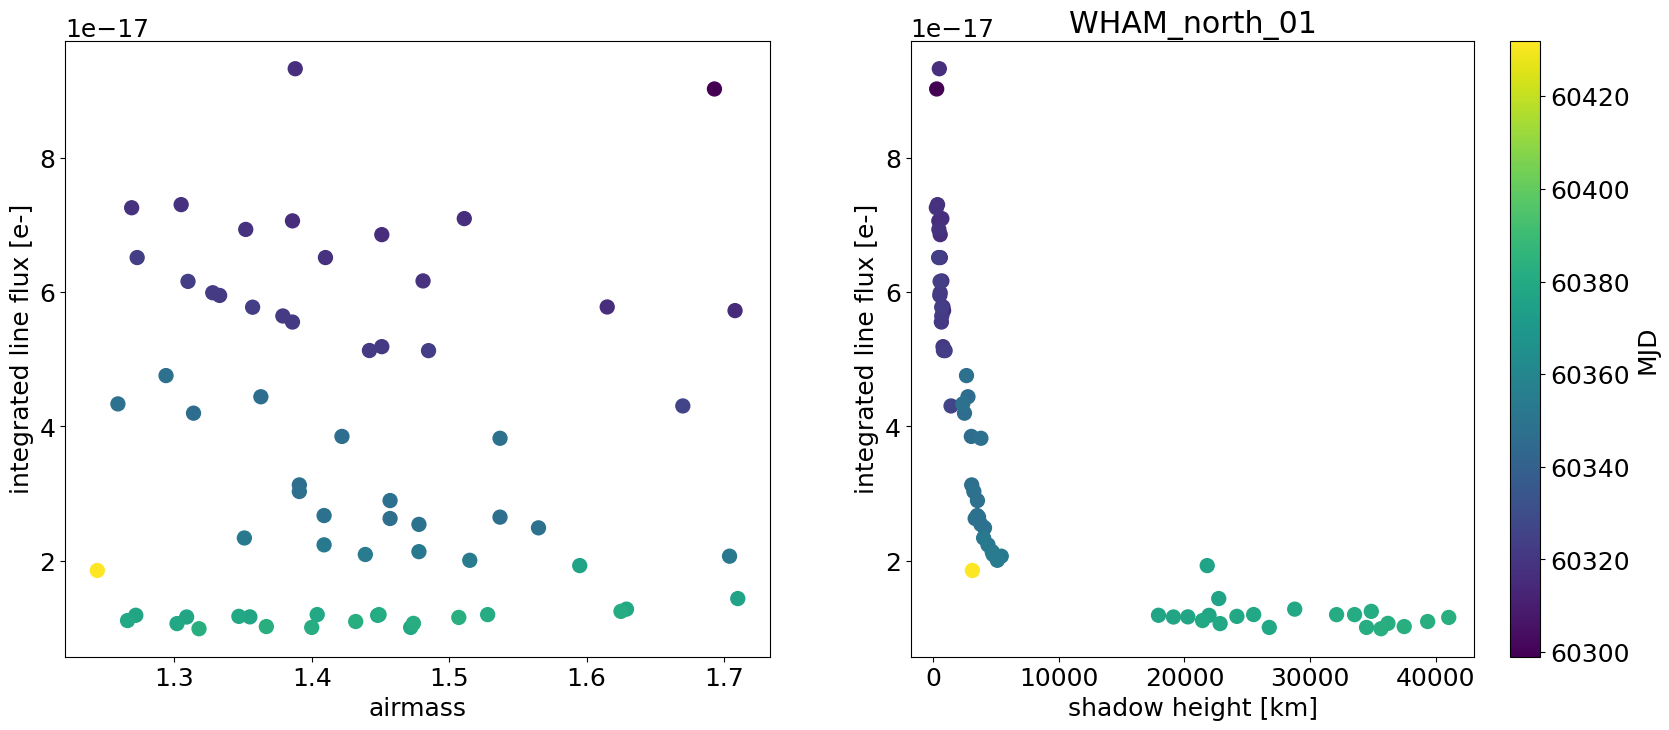

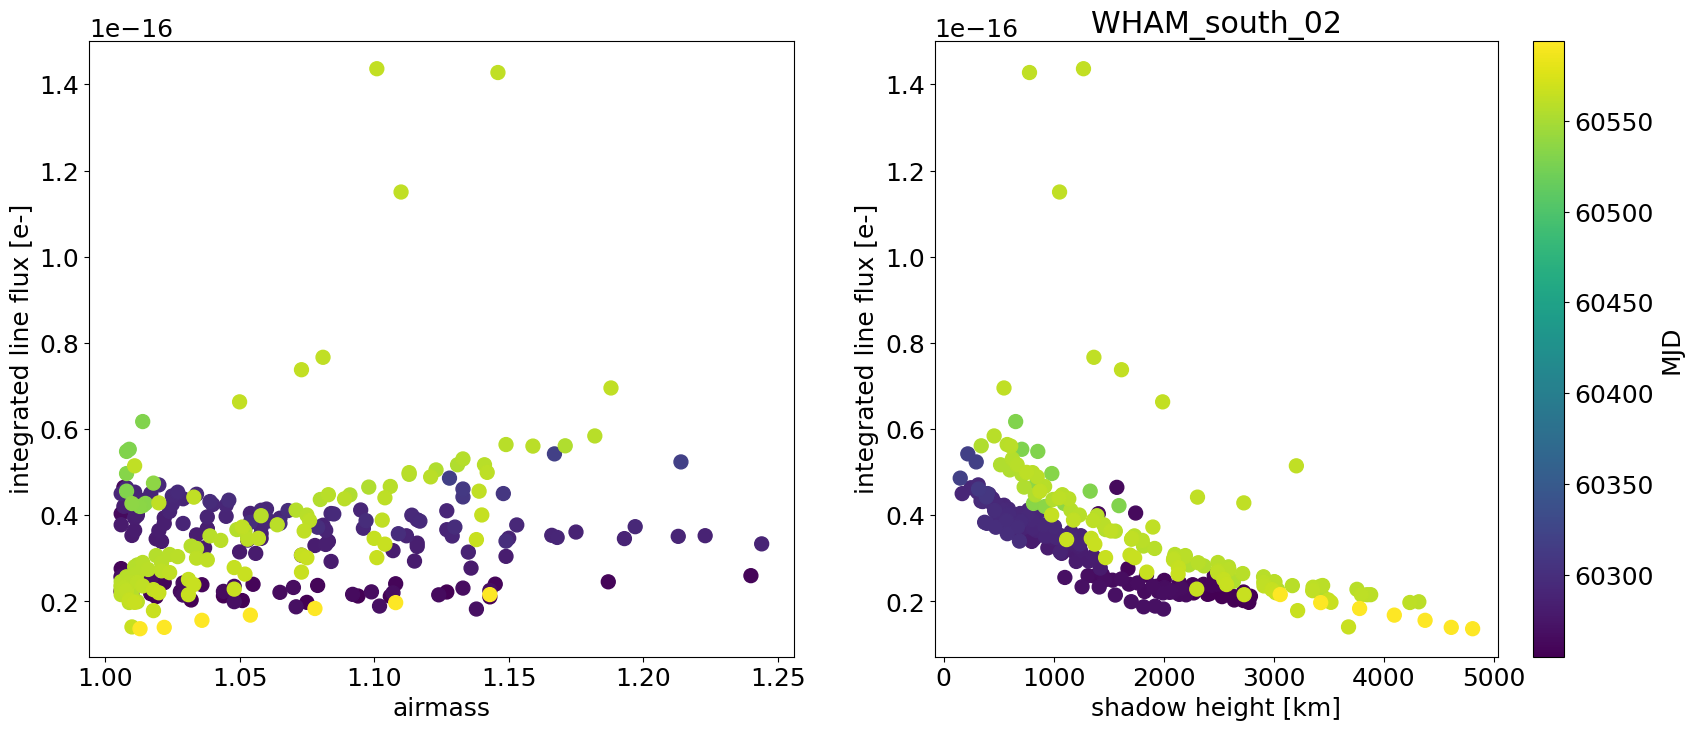

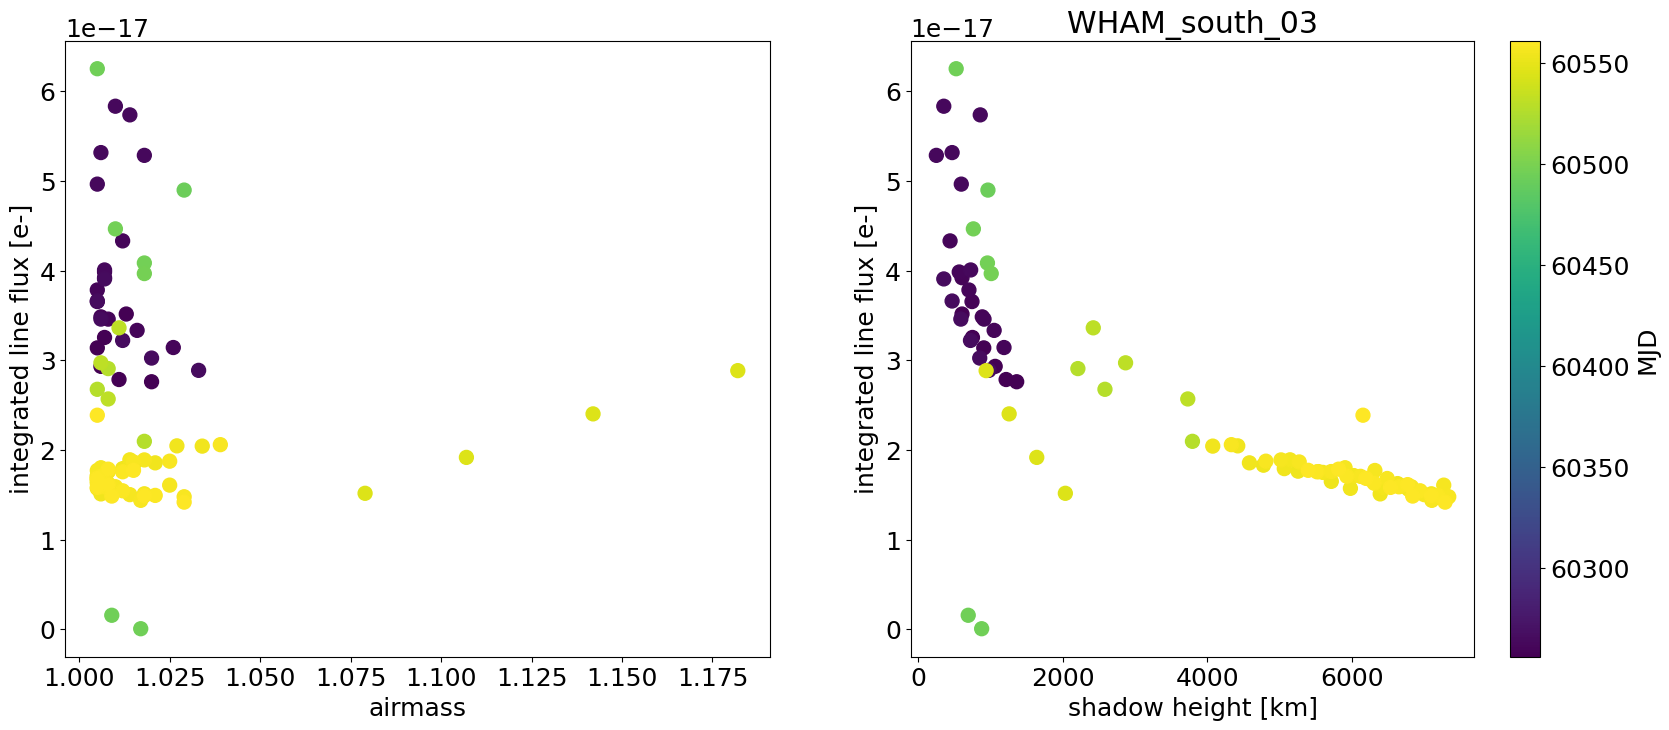

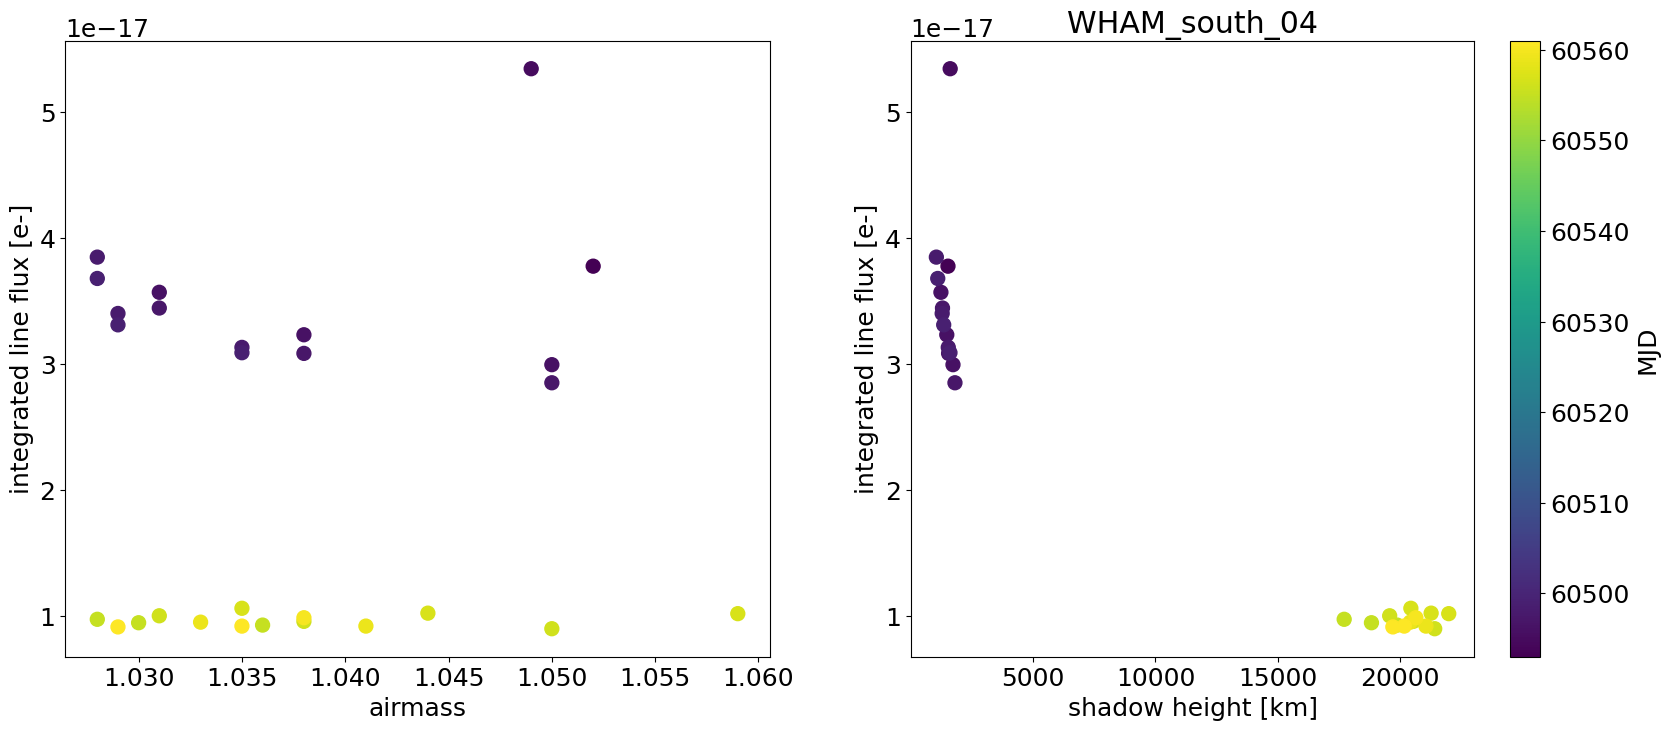

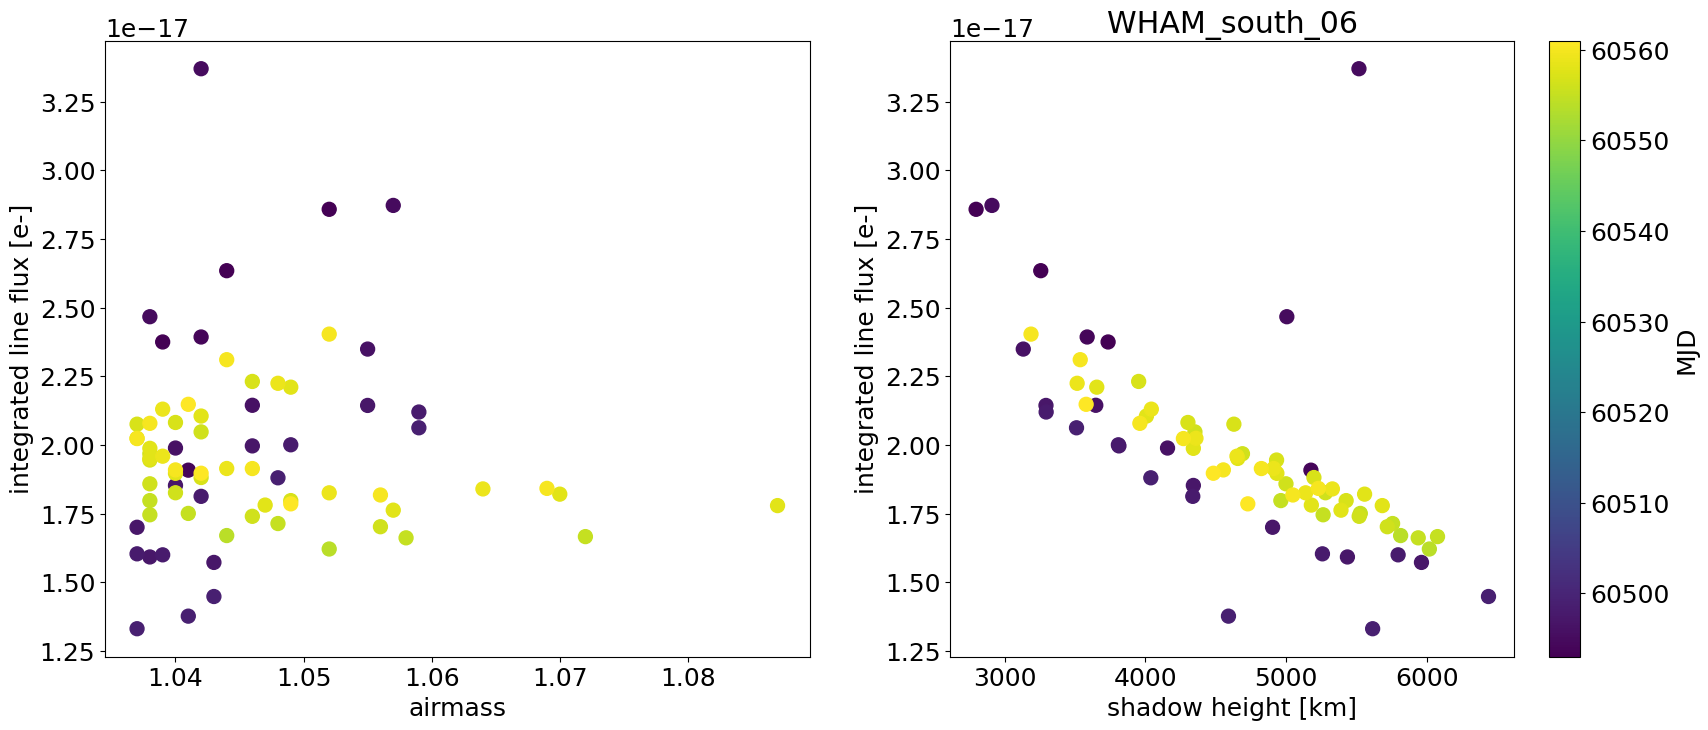

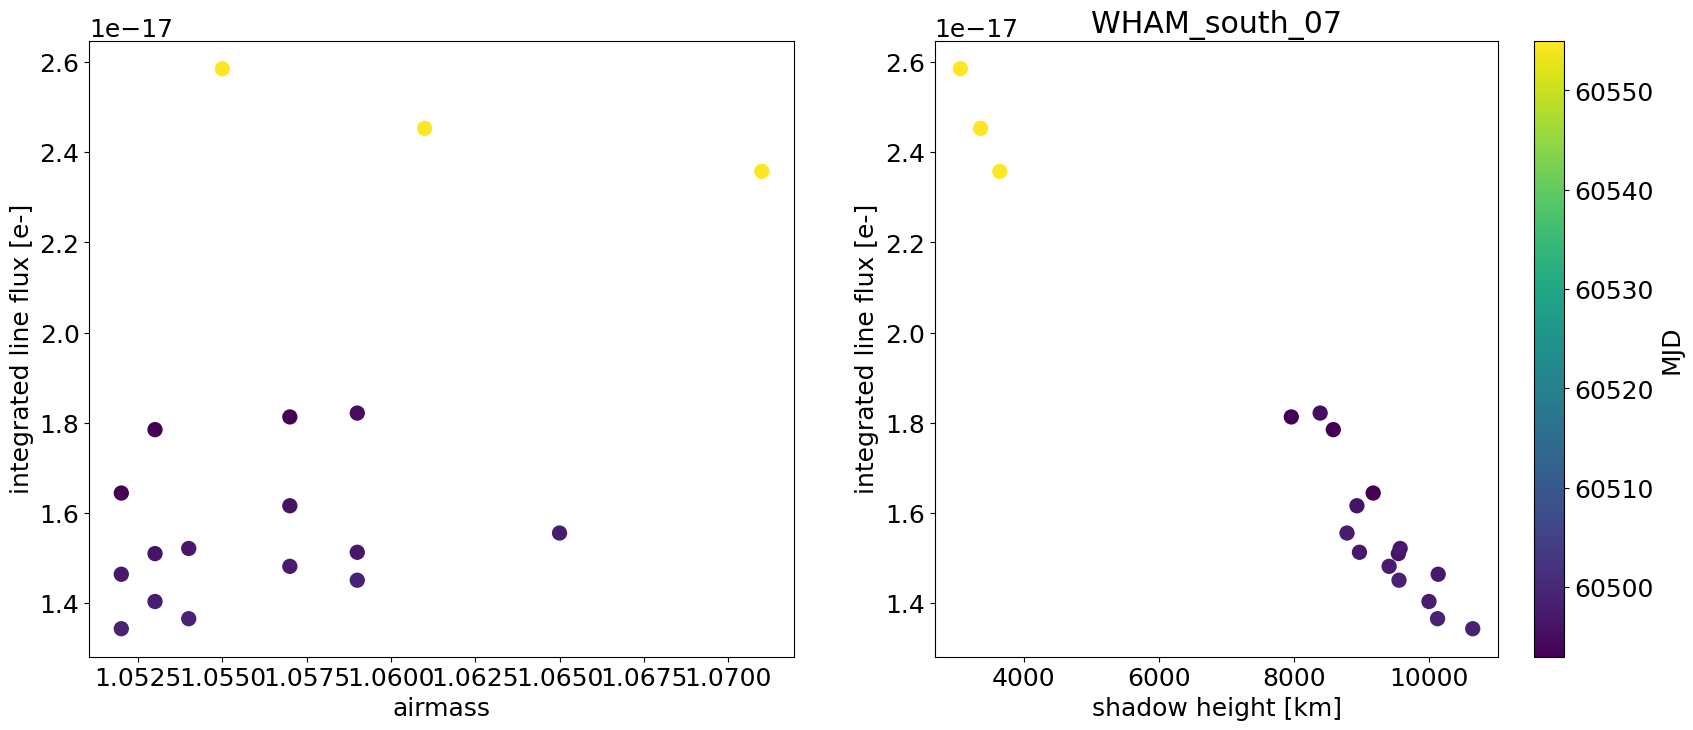

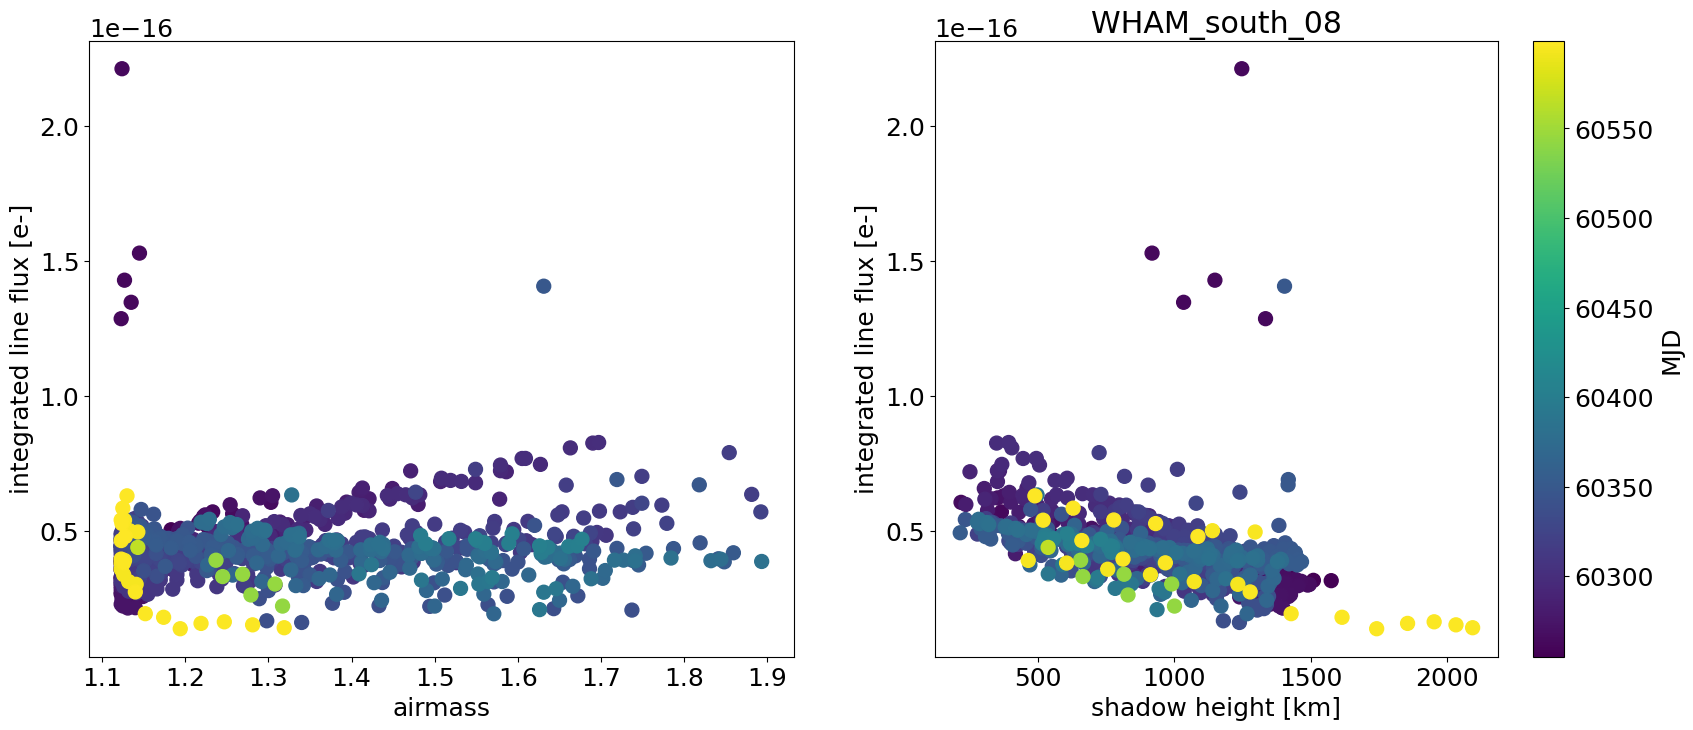

In [10]:
whams = table.unique(t, keys='wham')


for which_wham in whams['wham']:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    sub = t[t['wham']==which_wham]

    # Normalize the array vals so they can be mapped to a color
    c_norm = mpl.colors.Normalize(vmin=np.min(sub['mjd']), vmax=np.max(sub['mjd']))

    # Pick a colormap
    c_map  = mpl.cm.viridis

    # Scalar mappable of normalized array to colormap
    s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
    s_map.set_array([])

    axes[0].scatter(sub['am'],sub['flux'],s=100,color=s_map.to_rgba(sub['mjd']))
    axes[1].scatter(sub['hz'],sub['flux'],s=100,color=s_map.to_rgba(sub['mjd']))

    axes[0].set_xlabel('airmass')
    axes[0].set_ylabel('integrated line flux [e-]')

    plt.title(which_wham)

    axes[1].set_xlabel('shadow height [km]')
    axes[1].set_ylabel('integrated line flux [e-]')
    plt.colorbar(s_map, label=r'MJD')

/tmp/ipykernel_3890236/2206614721.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(s_map, label=r'MJD')


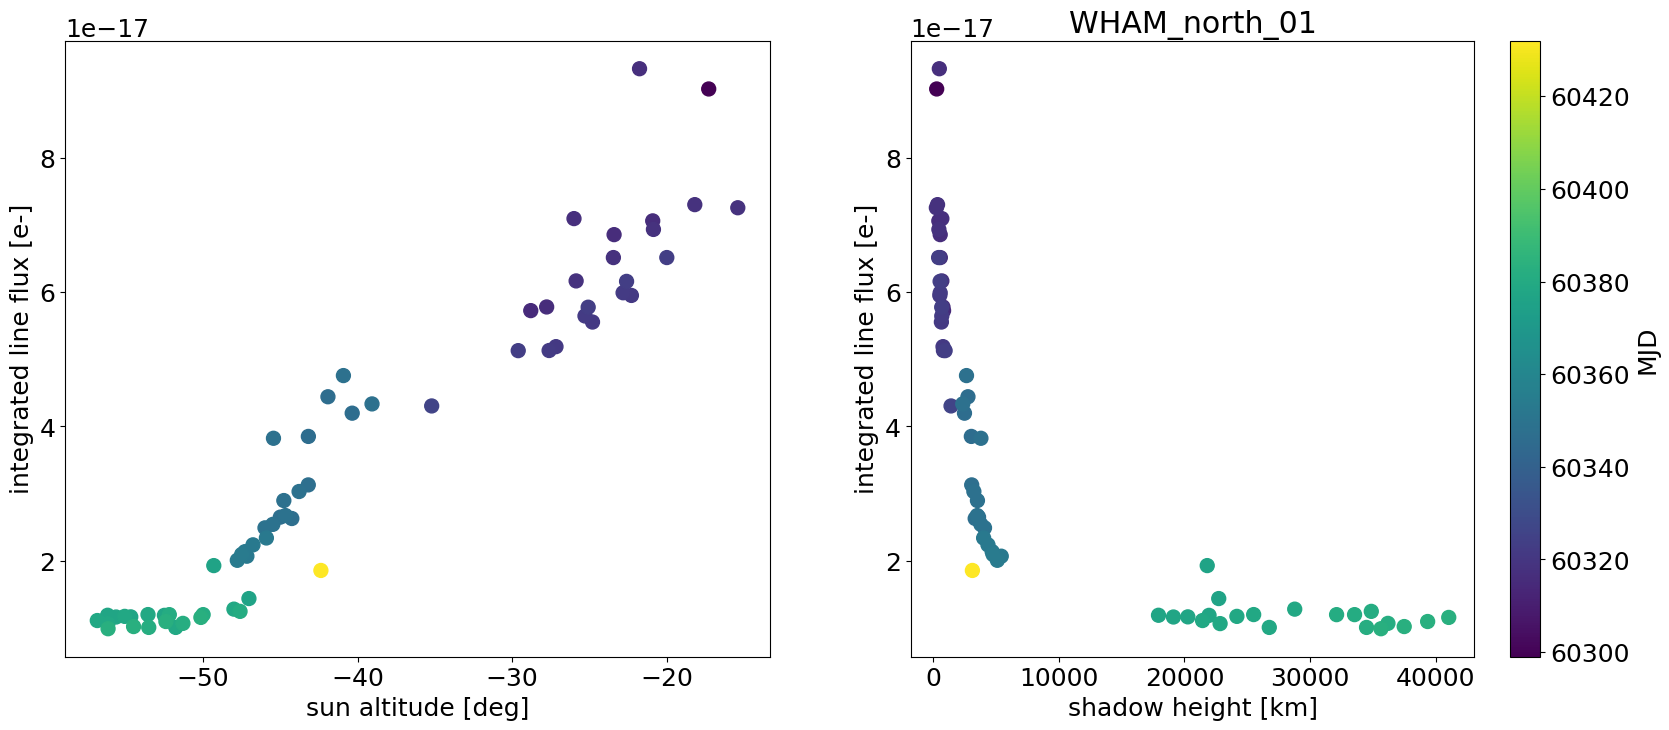

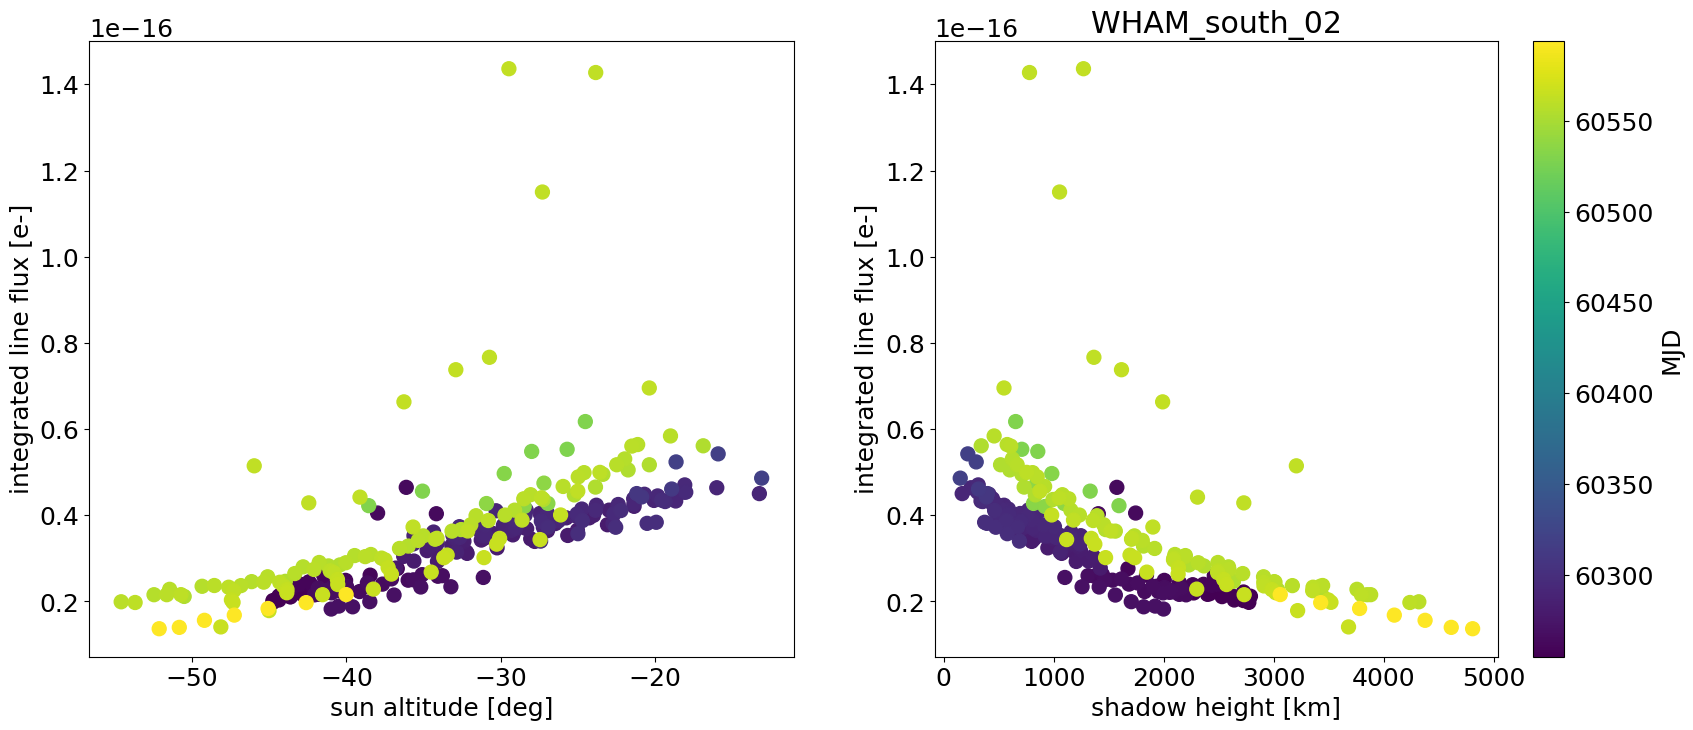

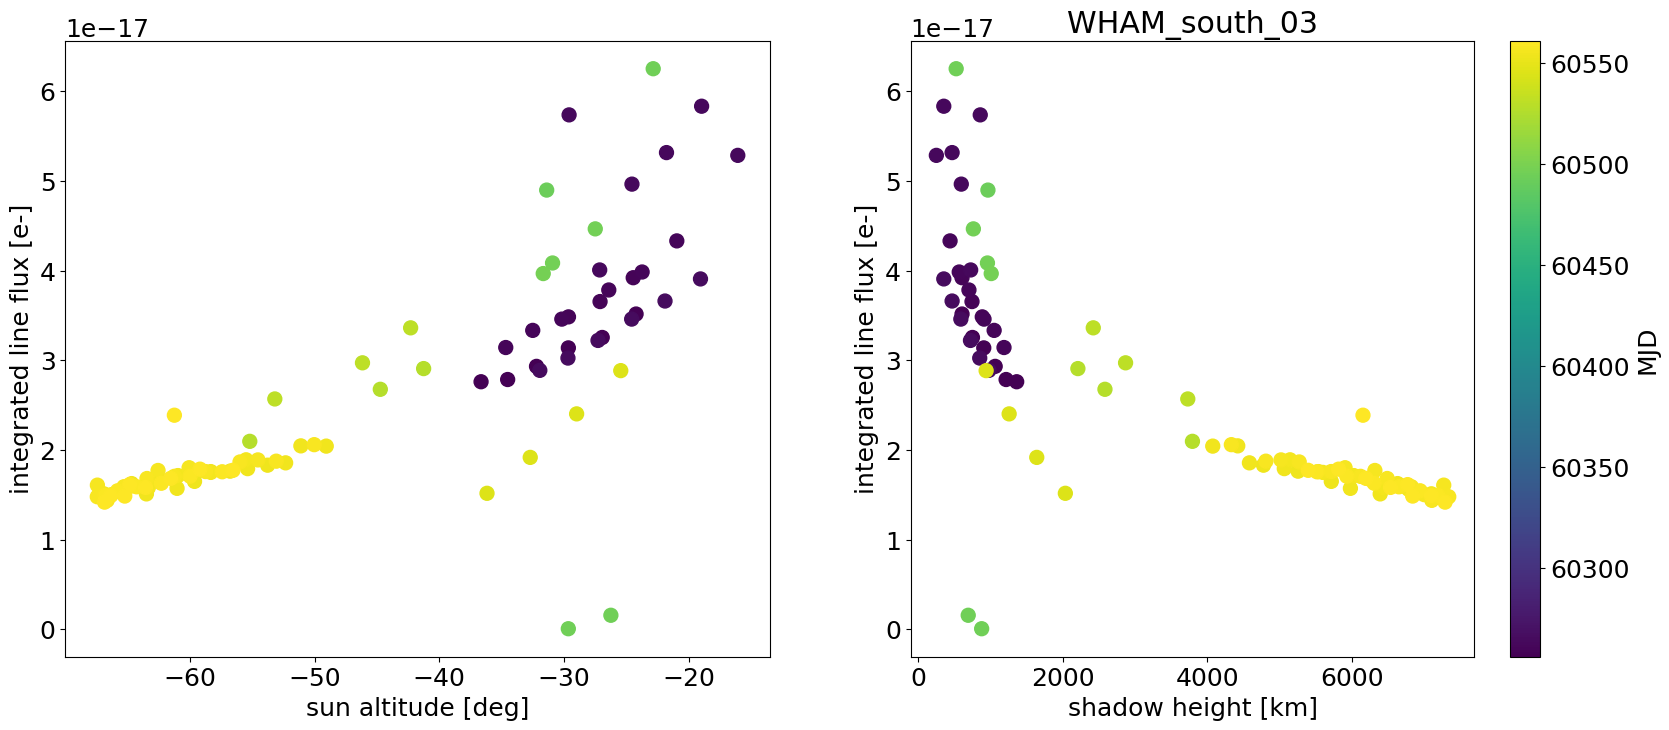

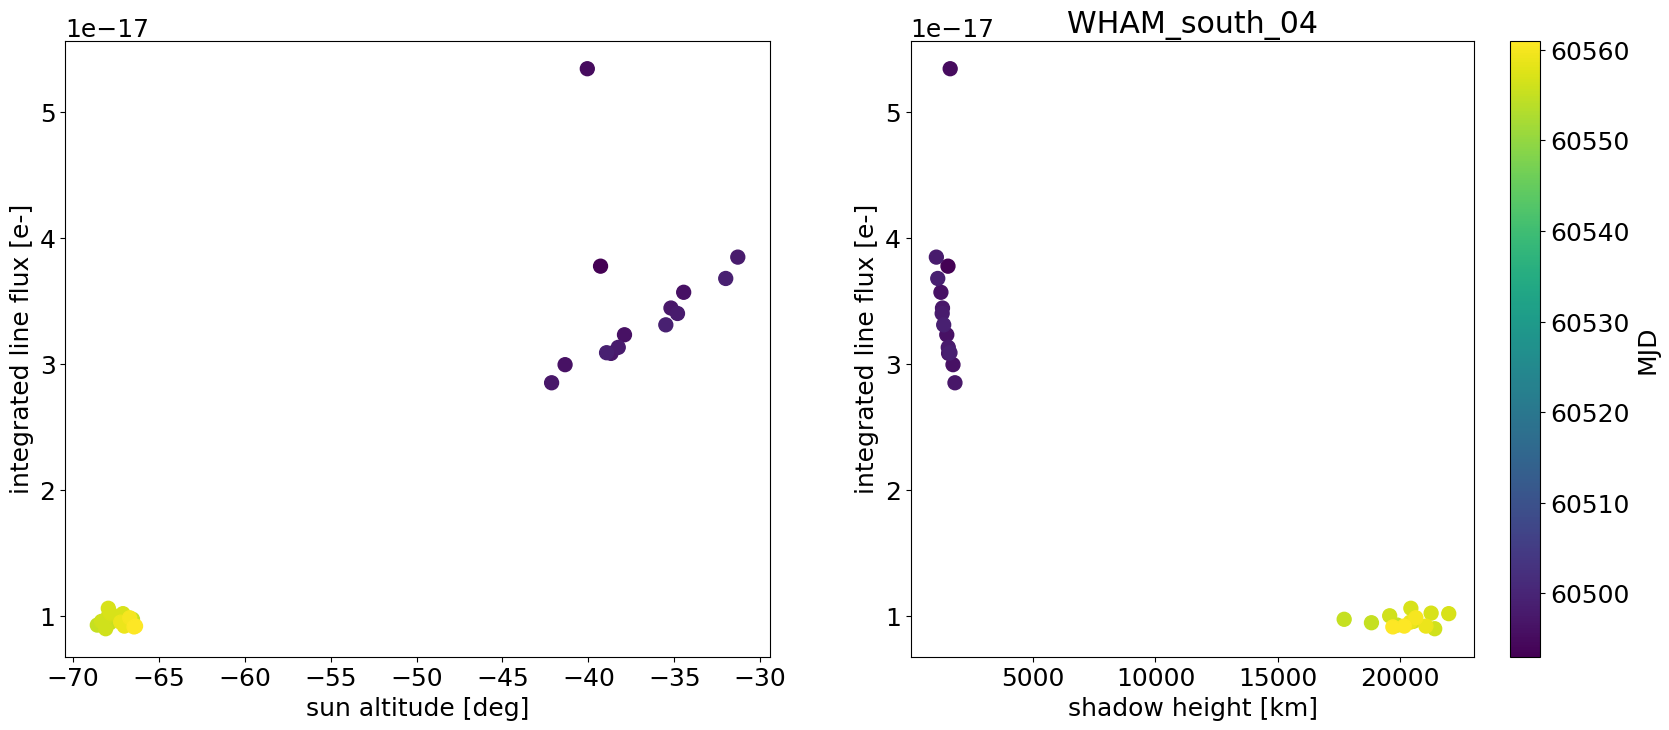

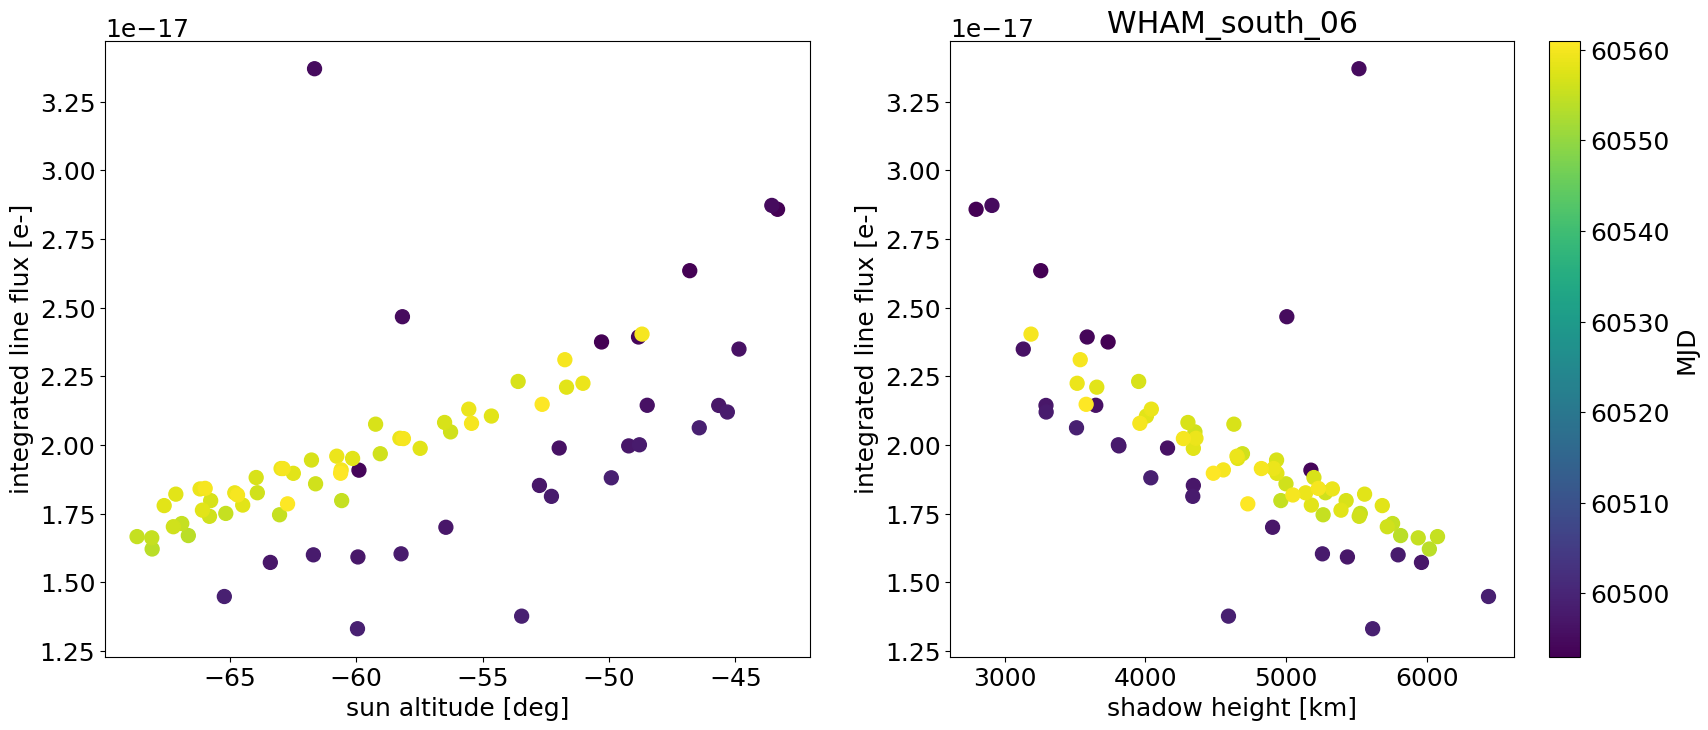

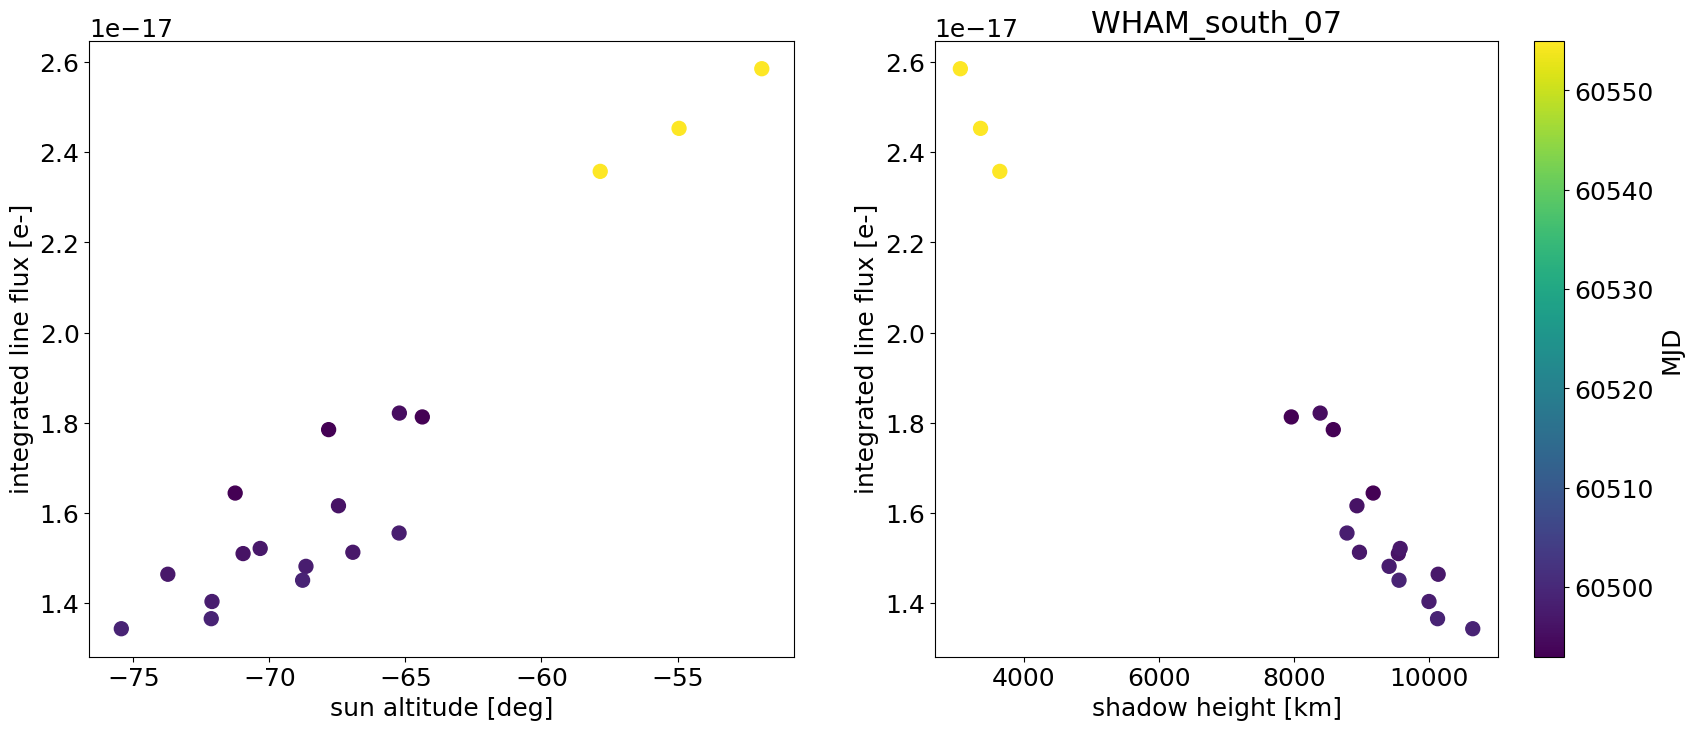

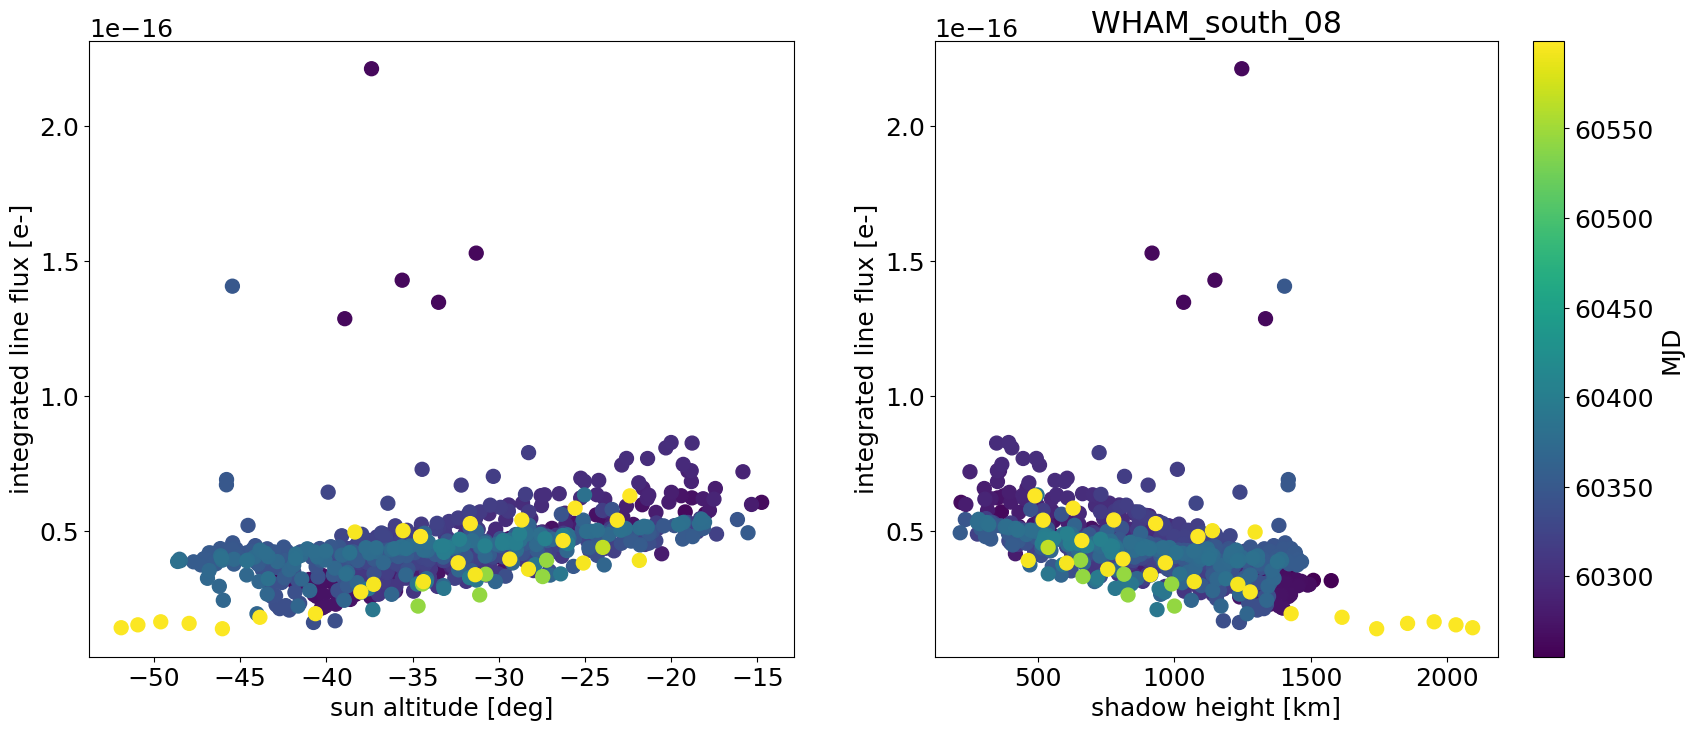

In [11]:
whams = table.unique(t, keys='wham')


for which_wham in whams['wham']:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    sub = t[t['wham']==which_wham]

    # Normalize the array vals so they can be mapped to a color
    c_norm = mpl.colors.Normalize(vmin=np.min(sub['mjd']), vmax=np.max(sub['mjd']))

    # Pick a colormap
    c_map  = mpl.cm.viridis

    # Scalar mappable of normalized array to colormap
    s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
    s_map.set_array([])
    
    axes[0].scatter(sub['sun_alt'],sub['flux'],s=100,color=s_map.to_rgba(sub['mjd']))
    axes[1].scatter(sub['hz'],sub['flux'],s=100,color=s_map.to_rgba(sub['mjd']))

    axes[0].set_xlabel('sun altitude [deg]')
    axes[0].set_ylabel('integrated line flux [e-]')

    plt.title(which_wham)

    axes[1].set_xlabel('shadow height [km]')
    axes[1].set_ylabel('integrated line flux [e-]')
    plt.colorbar(s_map, label=r'MJD')

/tmp/ipykernel_3856018/670607667.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(s_map, label=r'airmass')


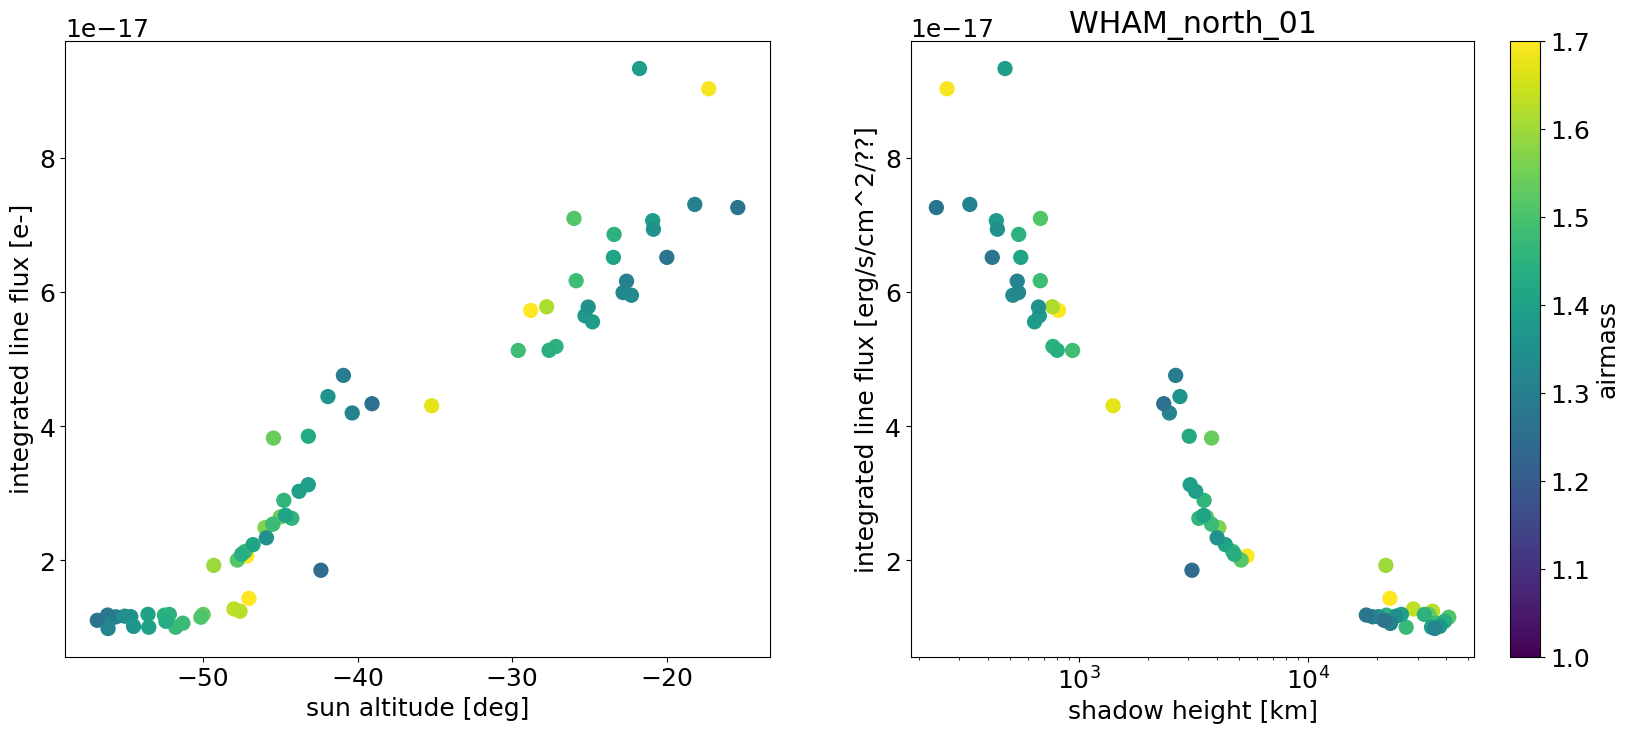

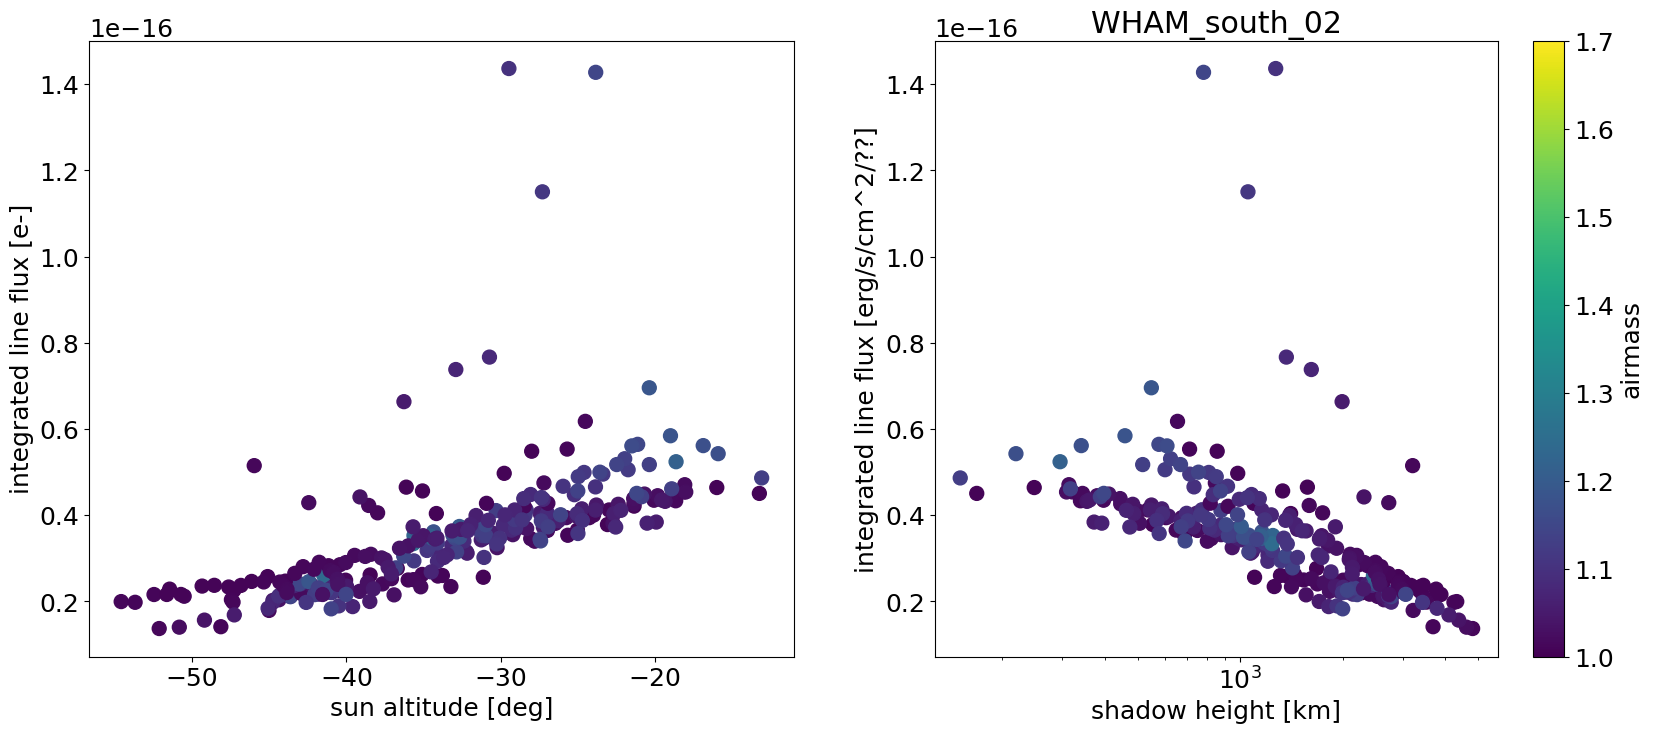

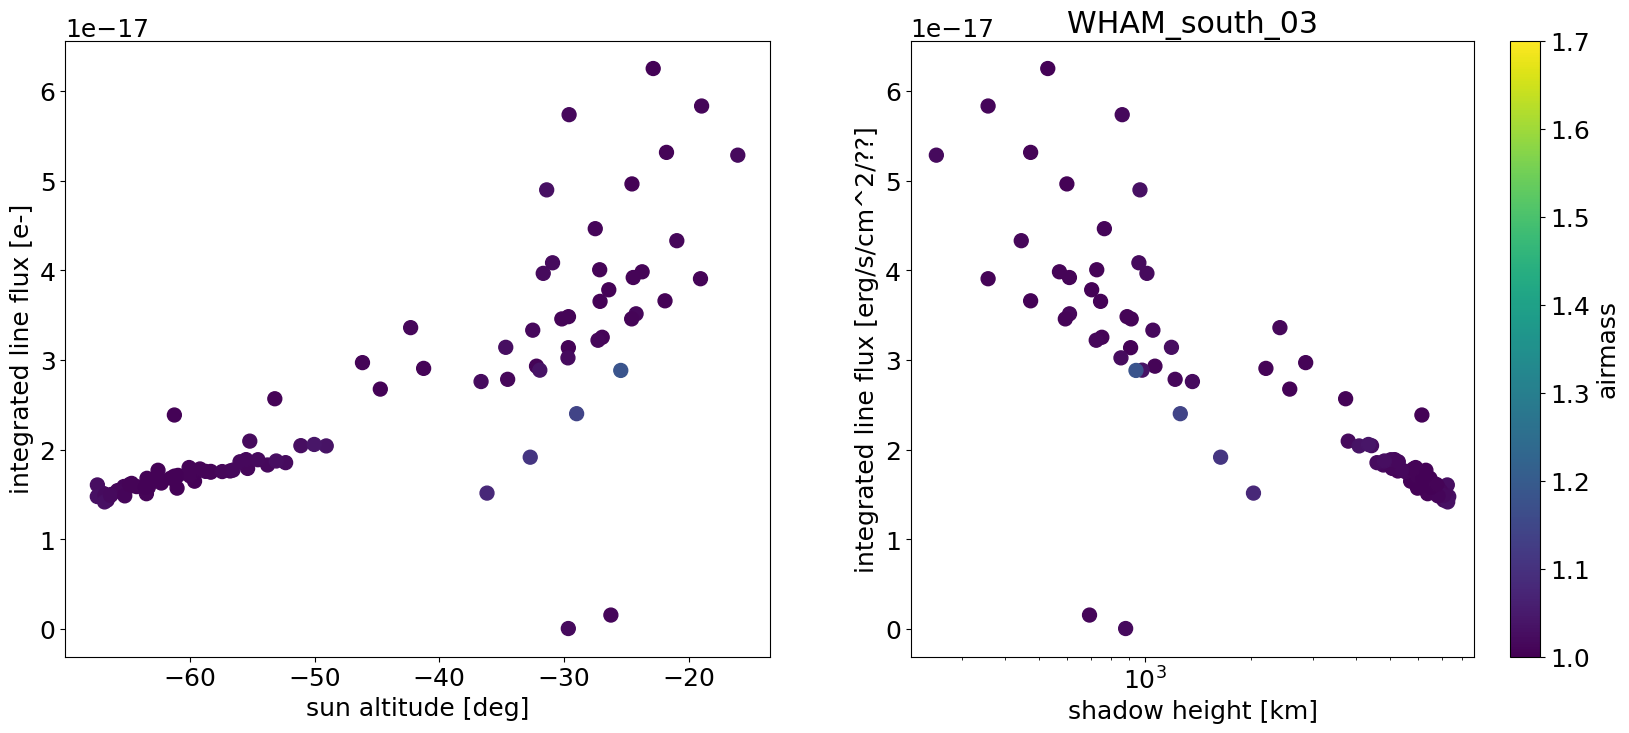

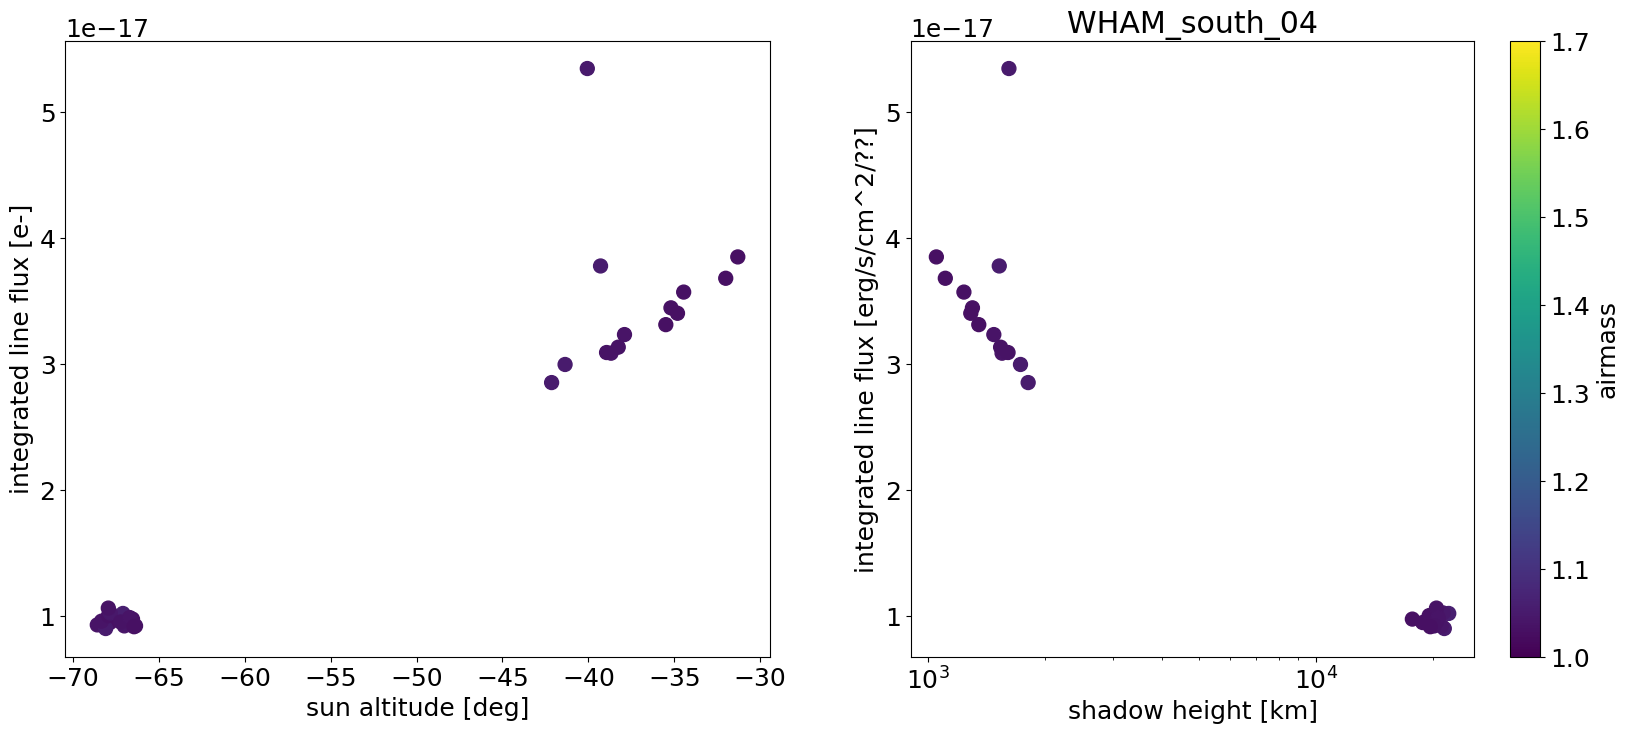

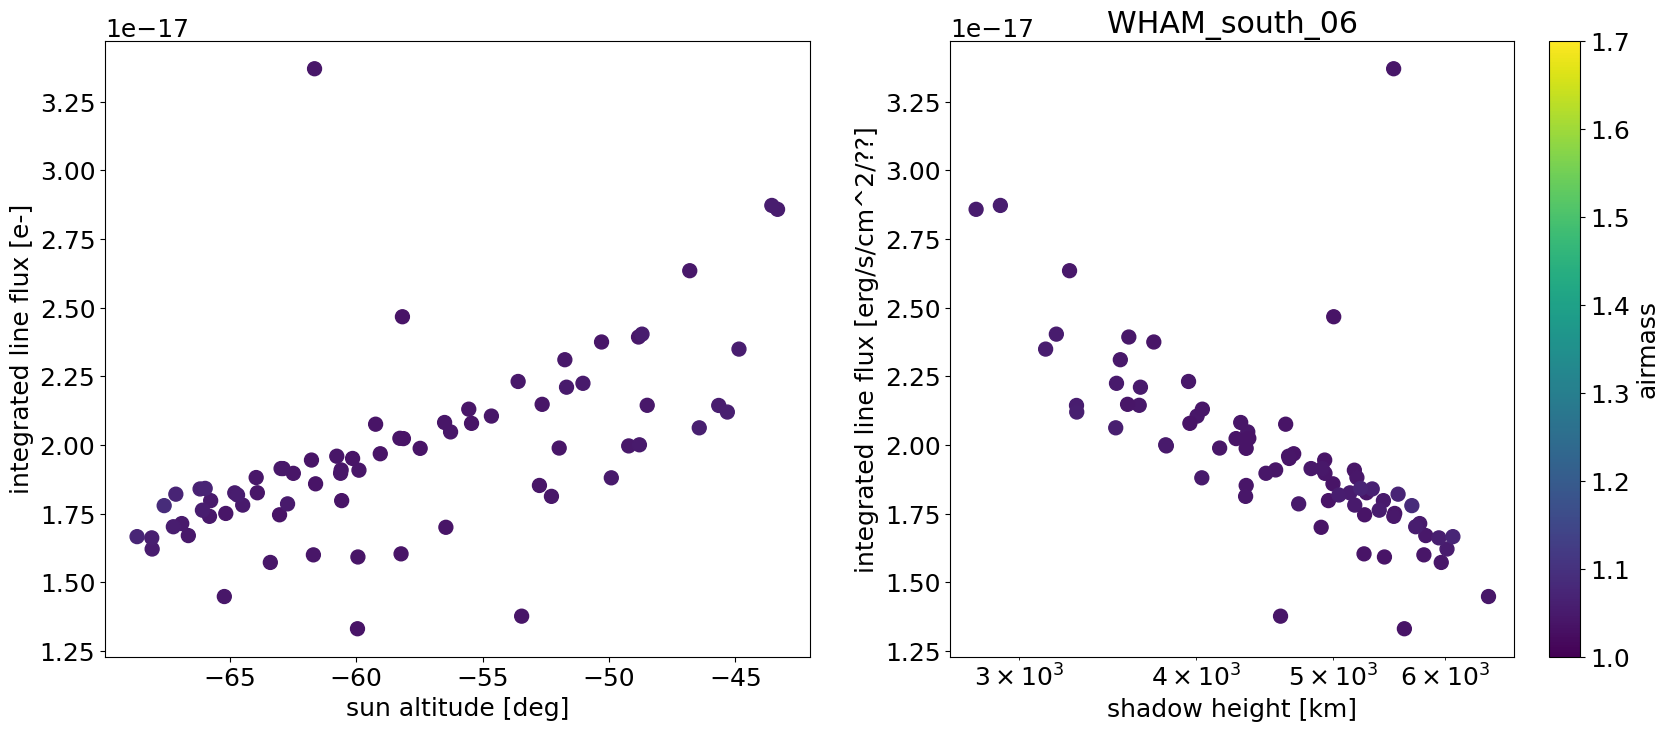

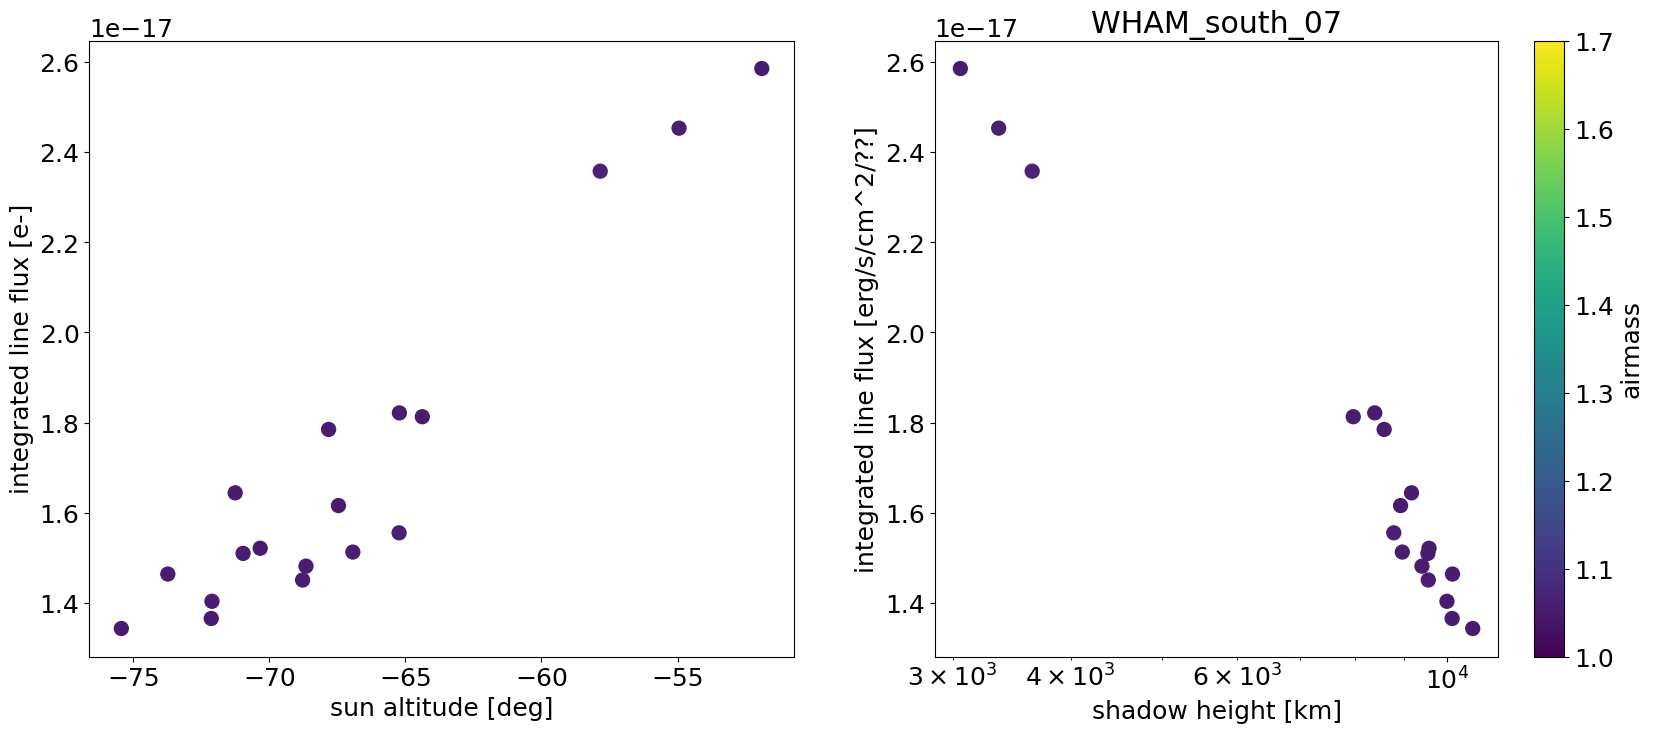

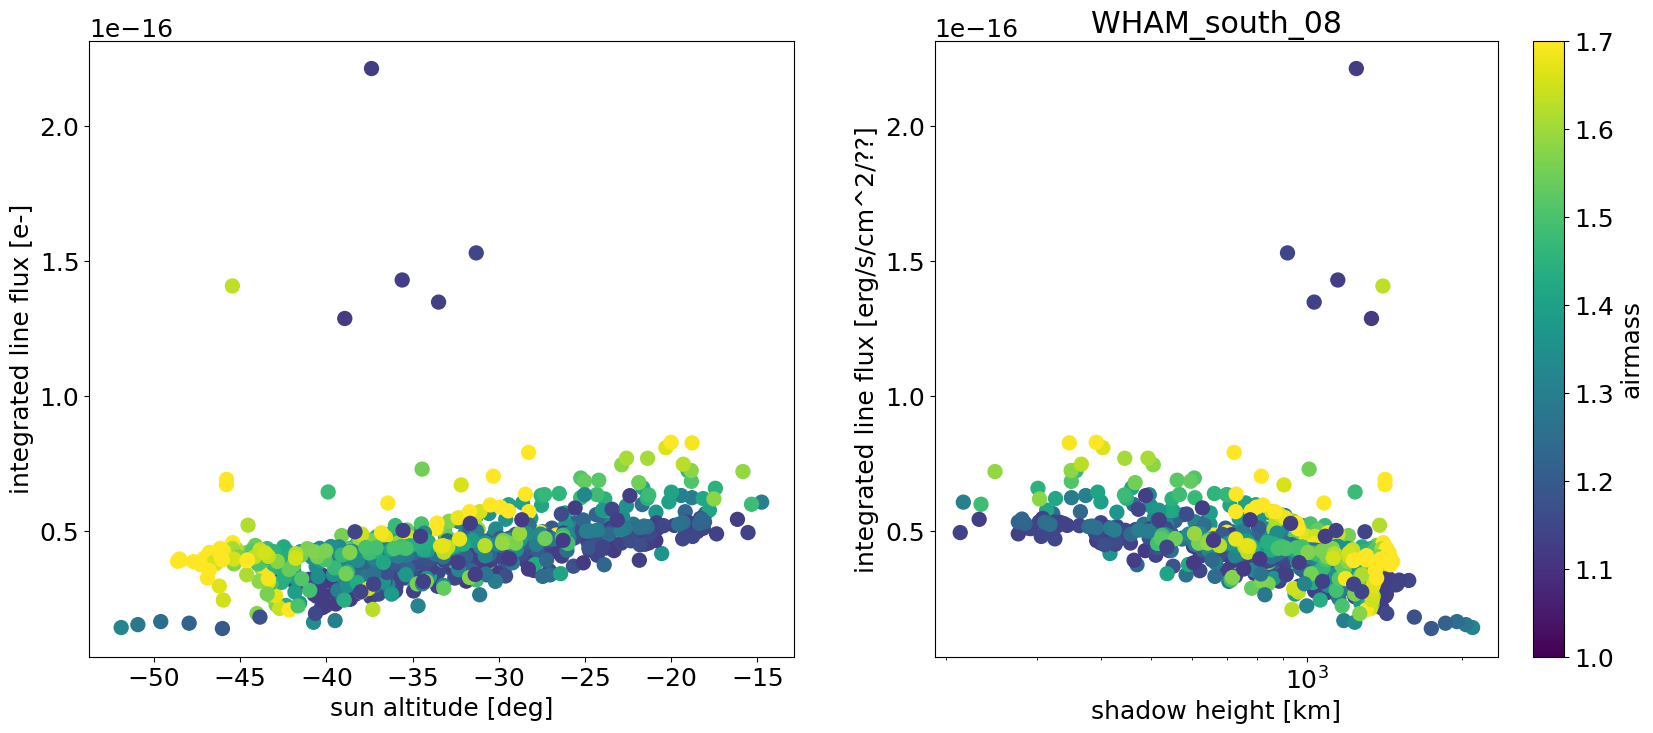

In [67]:
whams = table.unique(t, keys='wham')

# Normalize the array vals so they can be mapped to a color
c_norm = mpl.colors.Normalize(vmin=1, vmax=1.7)

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


for which_wham in whams['wham']:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    sub = t[t['wham']==which_wham]

    axes[0].scatter(sub['sun_alt'],sub['flux'],s=100,color=s_map.to_rgba(sub['am']))
    axes[1].scatter(sub['hz'],sub['flux'],s=100,color=s_map.to_rgba(sub['am']))

    axes[0].set_xlabel('sun altitude [deg]')
    axes[0].set_ylabel('integrated line flux [e-]')

    plt.title(which_wham)

    axes[1].set_xlabel('shadow height [km]')
    axes[1].set_ylabel('integrated line flux [erg/s/cm^2/??]')
    axes[1].set_xscale('log')
    plt.colorbar(s_map, label=r'airmass')

15


/tmp/ipykernel_3890236/575739153.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(s_map, label=r'airmass')


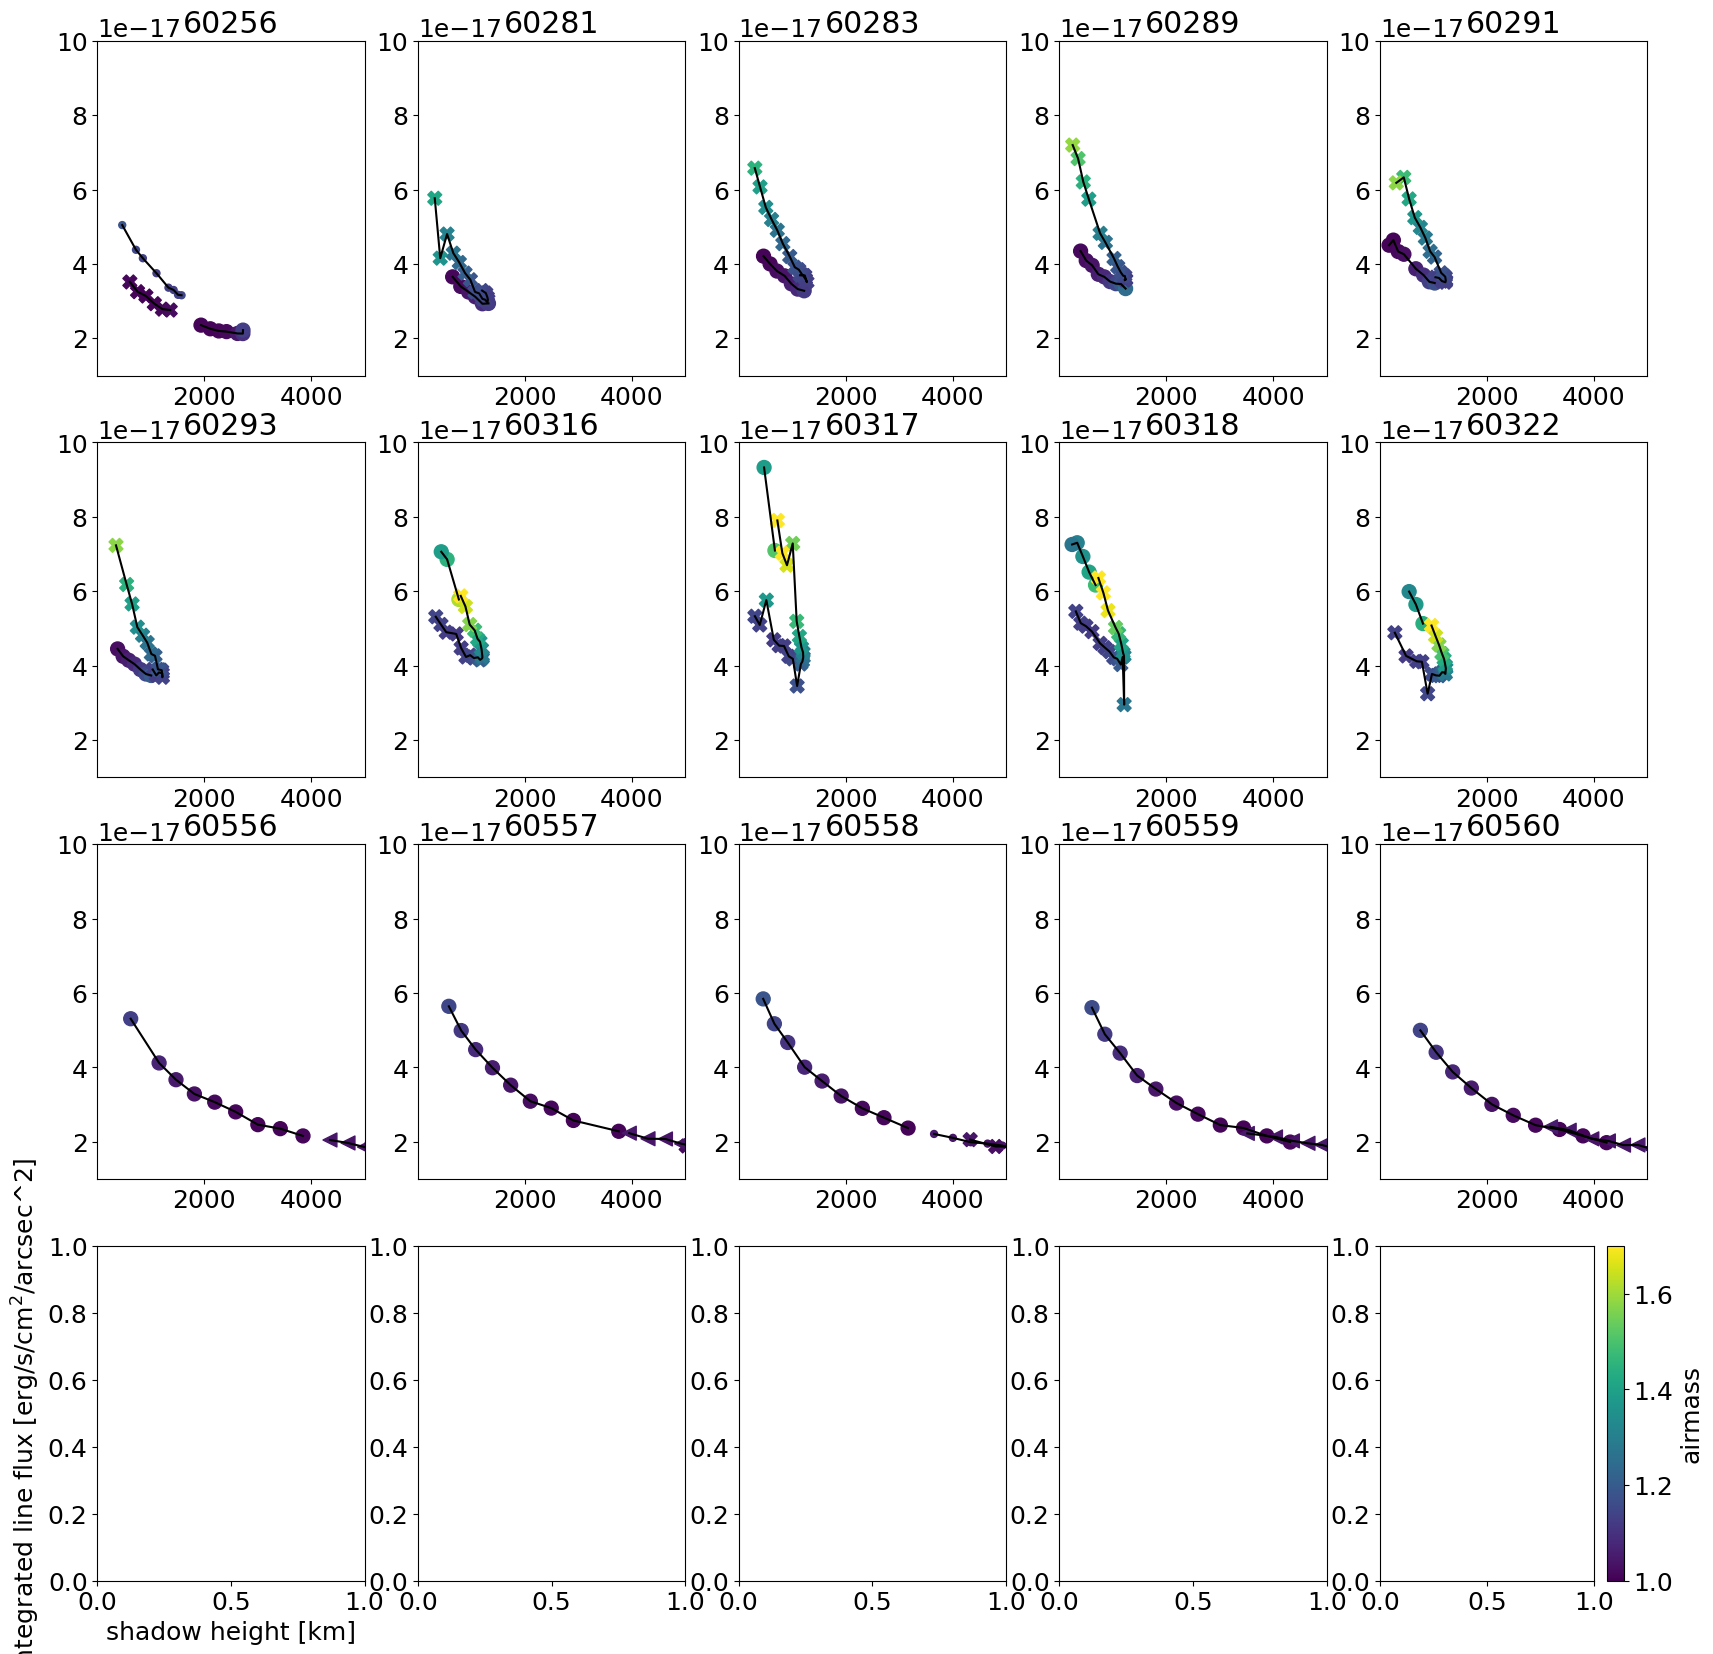

In [19]:
whams = table.unique(t, keys='wham')

# Normalize the array vals so they can be mapped to a color
#c_norm = mpl.colors.Normalize(vmin=60200, vmax=60335)
c_norm = mpl.colors.Normalize(vmin=1.0, vmax=1.7)

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


fig, axessq = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
axes = axessq.flat

nights = table.unique(t, keys='mjd')


ctr = 0
for n in nights['mjd']:
    iis = (t['mjd']==n)
    if (np.sum(iis) > 20) & (ctr < 20):
        sub1 = t[iis]

        whams = table.unique(sub1, keys='wham')

        if len(table.unique(sub1,'wham')) > 1:

            syms=['o','X','.','<']
            for i,which_wham in enumerate(whams['wham']):

                iis = (t['wham']==which_wham) & (t['mjd']==n)
                sub = t[iis]

    #            axes[0].plot(sub['am'],sub['flux'],color=s_map.to_rgba(n),marker=syms[i])
                #axes[ctr].plot(sub['hz'],sub['flux'],color=s_map.to_rgba(n),marker=syms[i],markersize=10)
                axes[ctr].plot(sub['hz'],sub['flux'],color='k')
                axes[ctr].scatter(sub['hz'],sub['flux'],s=100,color=s_map.to_rgba(sub['am']),marker=syms[i])#'o')
                axes[ctr].set_title(n)

                axes[ctr].set_ylim(0.1e-16,1e-16)
                axes[ctr].set_xlim(1,5000)
#                axes[ctr].set_xscale('log')

            ctr+=1

print(ctr)
#axes[0].set_xlabel('airmass')
#axes[0].set_ylabel('integrated line flux [e-]')


axes[15].set_xlabel('shadow height [km]')
axes[15].set_ylabel('integrated line flux [erg/s/cm$^2$/arcsec^2]')
plt.colorbar(s_map, label=r'airmass')

15


/tmp/ipykernel_3856018/2083946821.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(s_map, label=r'airmass')


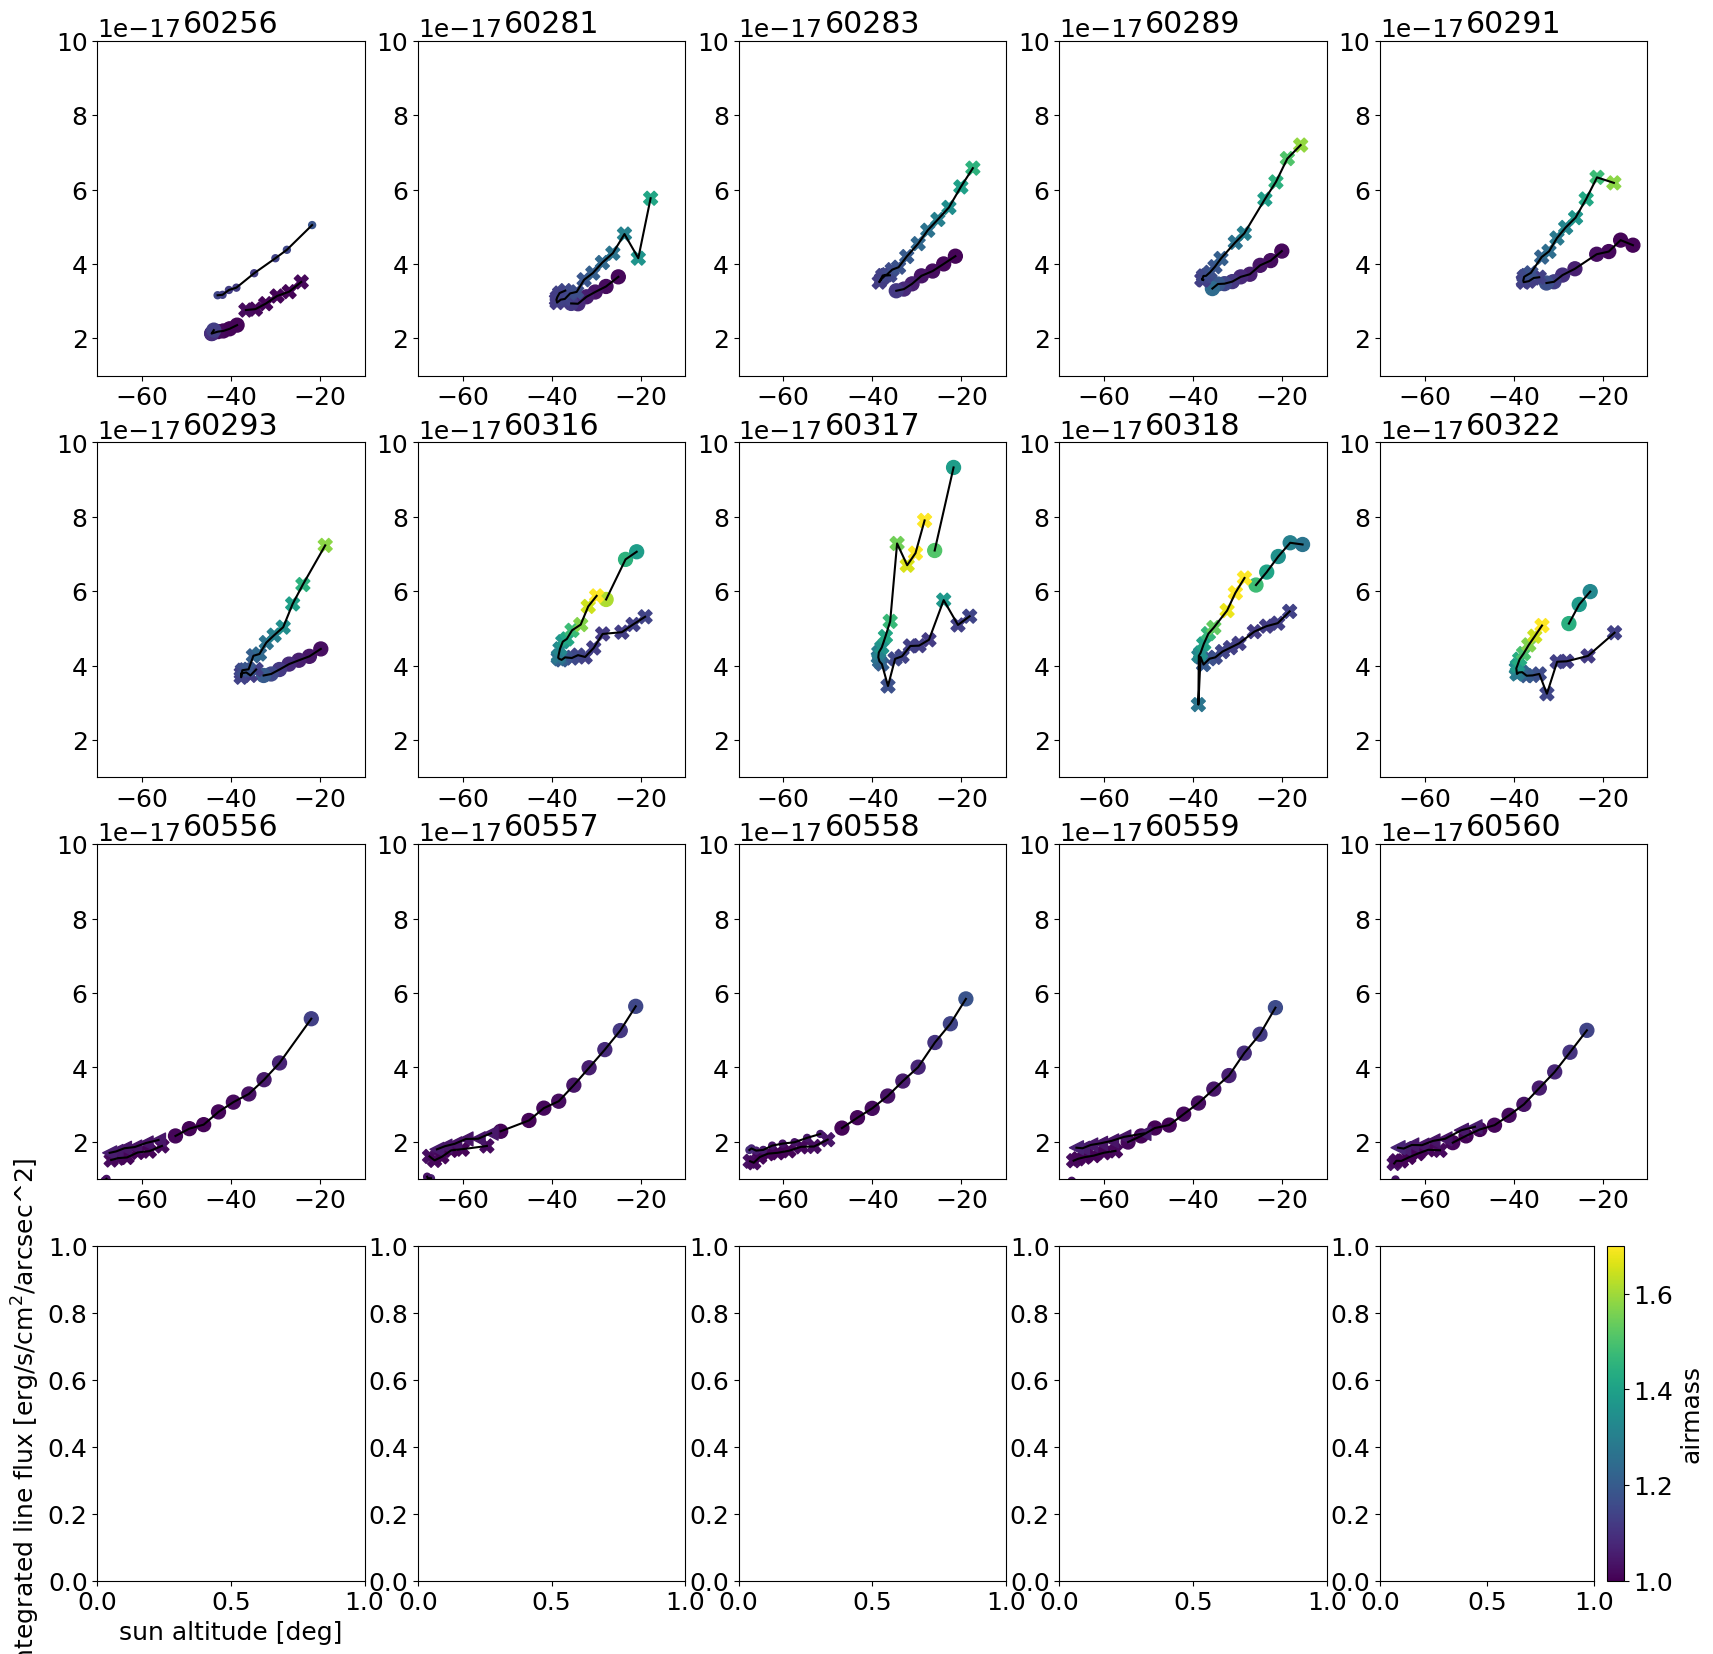

In [74]:
whams = table.unique(t, keys='wham')

# Normalize the array vals so they can be mapped to a color
#c_norm = mpl.colors.Normalize(vmin=60200, vmax=60335)
c_norm = mpl.colors.Normalize(vmin=1.0, vmax=1.7)

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


fig, axessq = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
axes = axessq.flat

nights = table.unique(t, keys='mjd')


ctr = 0
for n in nights['mjd']:
    iis = (t['mjd']==n)
    if (np.sum(iis) > 20) & (ctr < 20):
        sub1 = t[iis]

        whams = table.unique(sub1, keys='wham')

        if len(table.unique(sub1,'wham')) > 1:

            syms=['o','X','.','<']
            for i,which_wham in enumerate(whams['wham']):

                iis = (t['wham']==which_wham) & (t['mjd']==n)
                sub = t[iis]

    #            axes[0].plot(sub['am'],sub['flux'],color=s_map.to_rgba(n),marker=syms[i])
                #axes[ctr].plot(sub['hz'],sub['flux'],color=s_map.to_rgba(n),marker=syms[i],markersize=10)
                axes[ctr].plot(sub['sun_alt'],sub['flux'],color='k')
                axes[ctr].scatter(sub['sun_alt'],sub['flux'],s=100,color=s_map.to_rgba(sub['am']),marker=syms[i])#'o')
                axes[ctr].set_title(n)

                axes[ctr].set_ylim(0.1e-16,1e-16)
                axes[ctr].set_xlim(-70,-10)

            ctr+=1

print(ctr)
#axes[0].set_xlabel('airmass')
#axes[0].set_ylabel('integrated line flux [e-]')


axes[15].set_xlabel('sun altitude [deg]')
axes[15].set_ylabel('integrated line flux [erg/s/cm$^2$/arcsec^2]')
plt.colorbar(s_map, label=r'airmass')

15


/tmp/ipykernel_3856018/126522507.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(s_map, label=r'airmass')


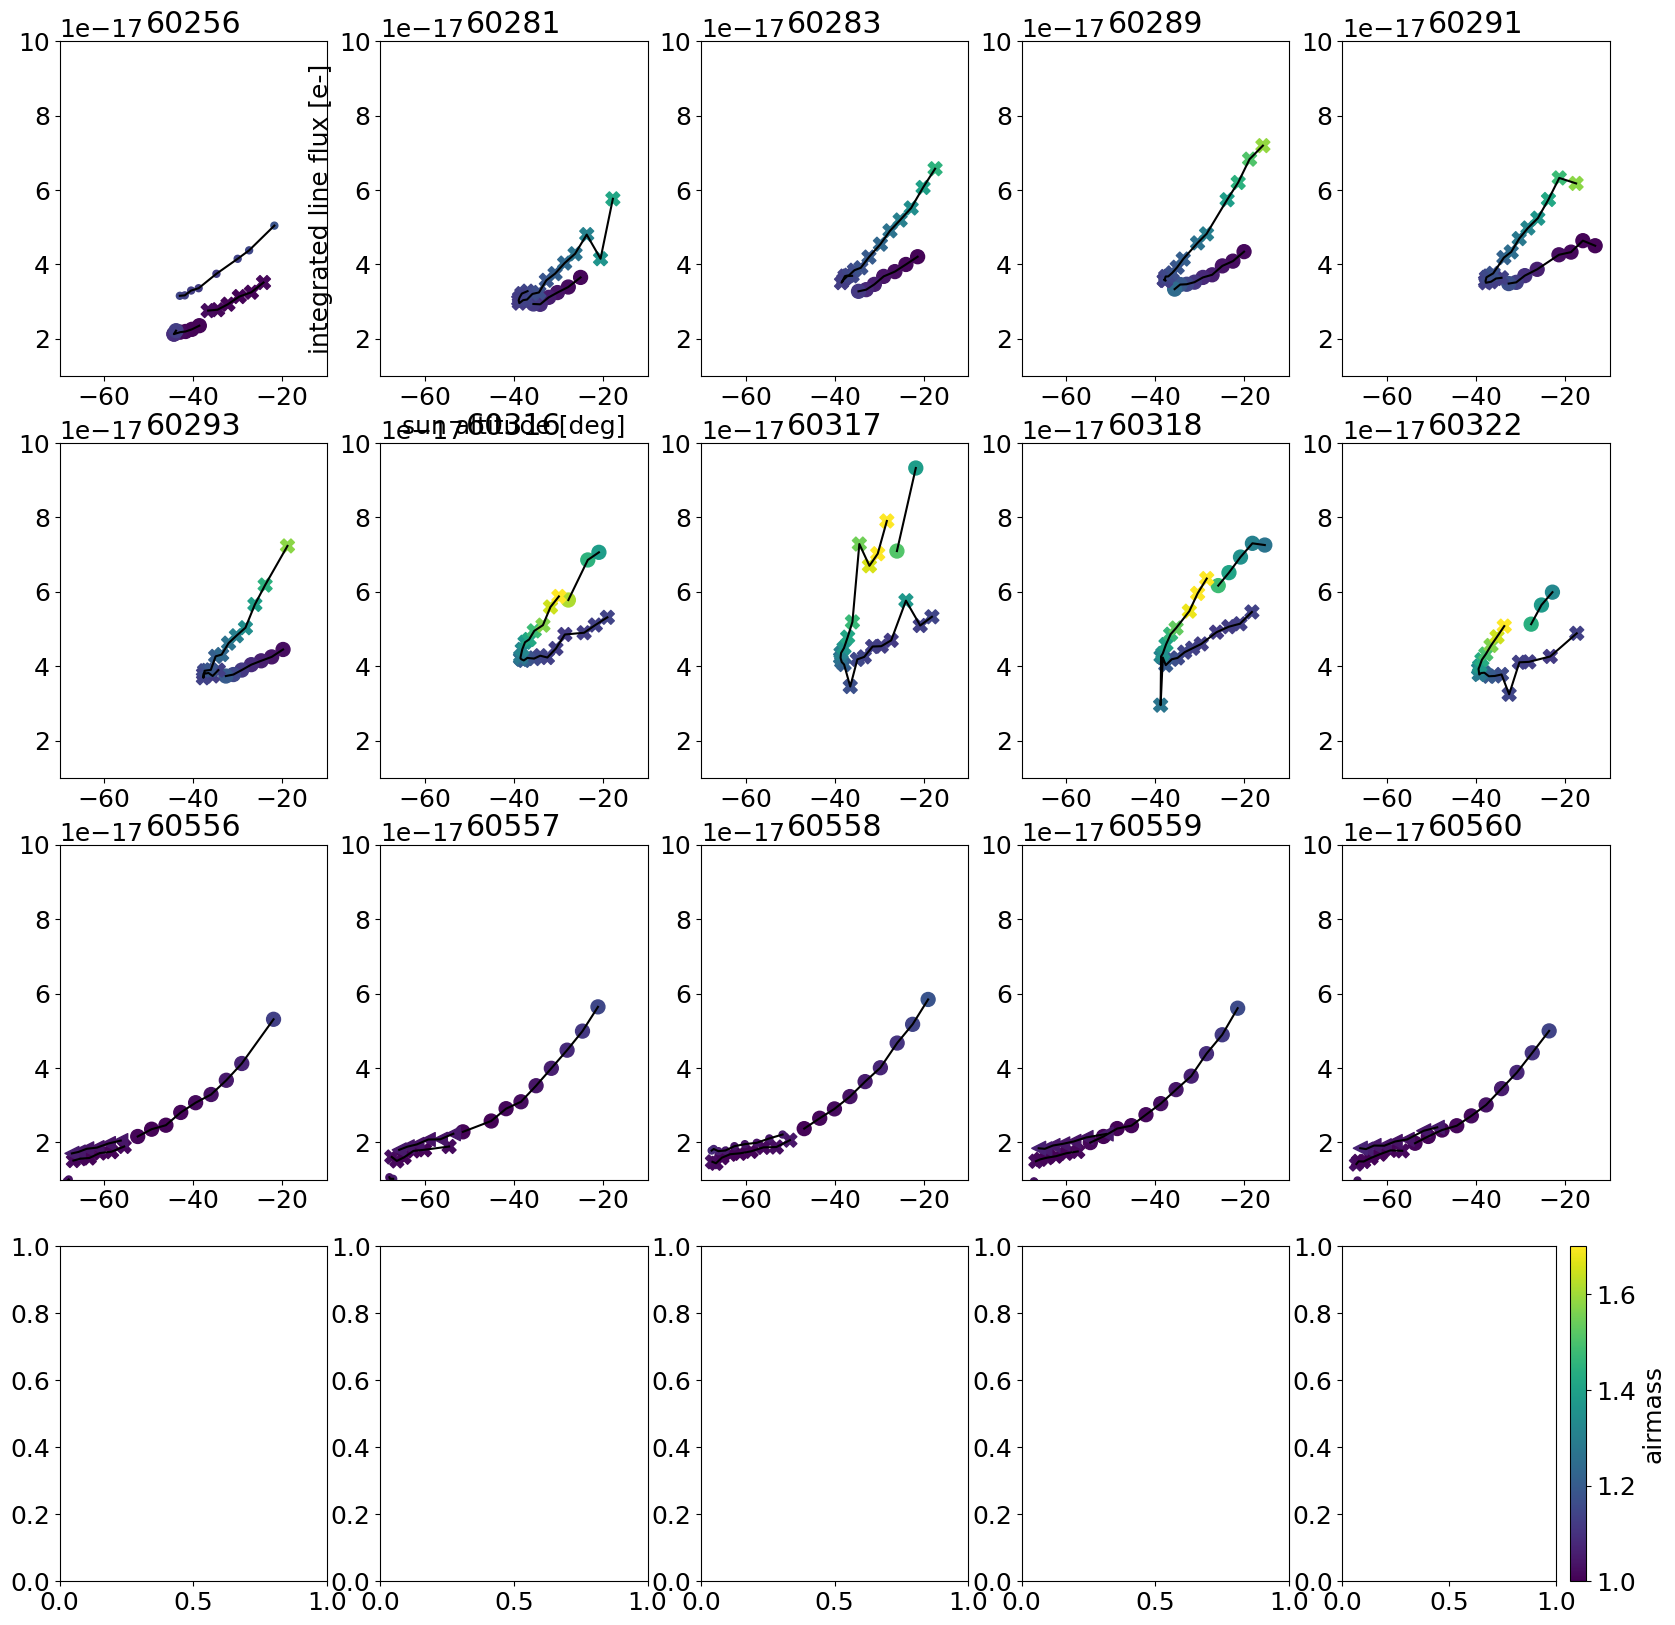

In [70]:
whams = table.unique(t, keys='wham')

# Normalize the array vals so they can be mapped to a color
#c_norm = mpl.colors.Normalize(vmin=60200, vmax=60335)
c_norm = mpl.colors.Normalize(vmin=1.0, vmax=1.7)

# Pick a colormap
c_map  = mpl.cm.viridis

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


fig, axessq = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
axes = axessq.flat

nights = table.unique(t, keys='mjd')


ctr = 0
for n in nights['mjd']:
    iis = (t['mjd']==n)
    if (np.sum(iis) > 20) & (ctr < 20):
        sub1 = t[iis]

        whams = table.unique(sub1, keys='wham')

        if len(table.unique(sub1,'wham')) > 1:

            syms=['o','X','.','<']
            for i,which_wham in enumerate(whams['wham']):

                iis = (t['wham']==which_wham) & (t['mjd']==n)
                sub = t[iis]

                ff = sub['flux']
    #            axes[0].plot(sub['am'],sub['flux'],color=s_map.to_rgba(n),marker=syms[i])
                #axes[ctr].plot(sub['hz'],sub['flux'],color=s_map.to_rgba(n),marker=syms[i],markersize=10)
                axes[ctr].plot(sub['sun_alt'],sub['flux'],color='k')
                axes[ctr].scatter(sub['sun_alt'],sub['flux'],s=100,color=s_map.to_rgba(sub['am']),marker=syms[i])#'o')
                axes[ctr].set_title(n)

                axes[ctr].set_ylim(0.1e-16,1e-16)
                axes[ctr].set_xlim(-70,-10)

            ctr+=1

print(ctr)
#axes[0].set_xlabel('airmass')
#axes[0].set_ylabel('integrated line flux [e-]')


axes[15].set_xlabel('sun altitude [deg]')
axes[15].set_ylabel('integrated line flux [e-]')
plt.colorbar(s_map, label=r'airmass')

In [47]:
np.exp(0.14*(1.0 - 1.0))

1.0

In [51]:
testfile = '/data/LVM/sdsswork/lvm/spectro/redux/1.1.0/1044XX/1044057/60395/lvmSFrame-00015010.fits'
drpall = table.Table.read('/data/LVM/sdsswork/lvm/spectro/redux/1.1.0/drpall-1.1.0.fits')
ii=testfile.find('sdsswork')
dd = drpall[testfile[ii:] == drpall['location']]

dd

<Table length=1>
tilegrp  tileid ... calib_mjd
 bytes6  int64  ...   int64  
------- ------- ... ---------
 1044XX 1044057 ...     60388

Text(0, 0.5, 'geocoronal Ha [R]')

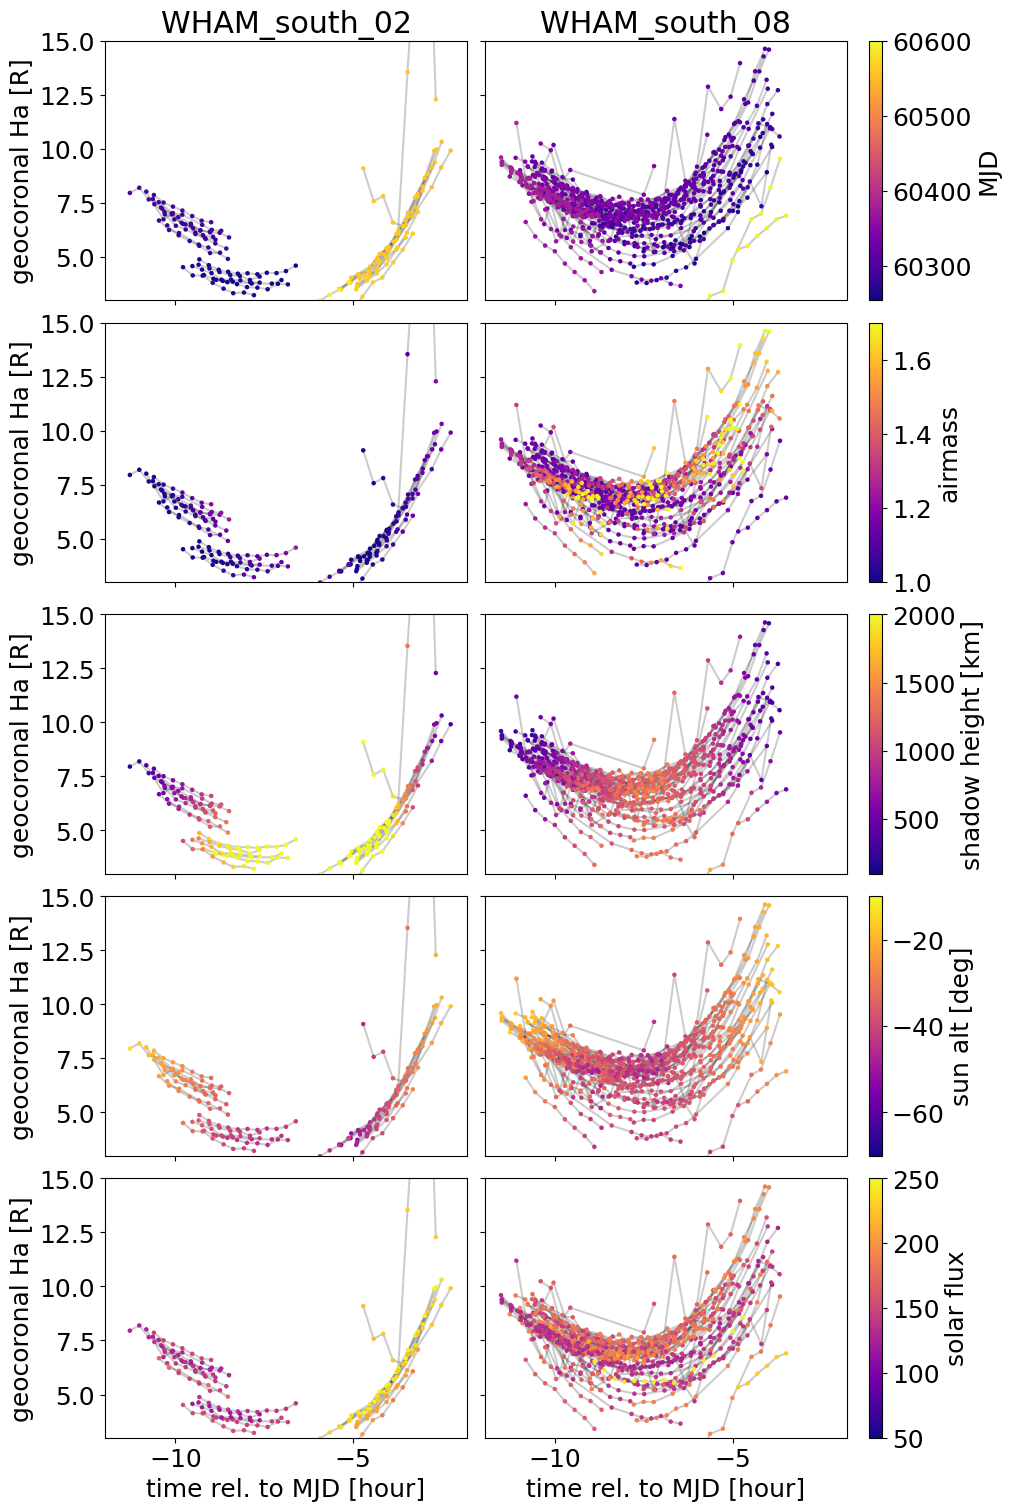

In [83]:
def p1(axes,sub, cc, c_norm):
    s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
    s_map.set_array([])
    scl = 24.
    axes.plot(sub['time'].data[:,1]*scl,forward(sub['flux']),color='k',alpha=0.2)
    axes.scatter(sub['time'].data[:,1]*scl,forward(sub['flux']),c = s_map.to_rgba(cc),s=5,zorder=10)
    return s_map

whams = table.unique(t, keys='wham')


# Pick a colormap
#c_map  = mpl.cm.viridis
c_map  = mpl.cm.plasma

c_norm = mpl.colors.Normalize(vmin=np.min(t['mjd']), vmax=60600)
c_norm2 = mpl.colors.Normalize(vmin=1.0, vmax=1.7)
c_norm3 = mpl.colors.Normalize(vmin=100, vmax=2000)
c_norm4 = mpl.colors.Normalize(vmin=-70, vmax=-10)
c_norm5 = mpl.colors.Normalize(vmin=50, vmax=250)


fig, axesgrd = plt.subplots(nrows=5, ncols=2, figsize=(10, 15),sharex=True,sharey=True,gridspec_kw={'hspace': 0,'wspace':0},layout='constrained')

nights = table.unique(t, keys='mjd')

scl = 24.

#which_wham = 'WHAM_south_08'
which_wham = 'WHAM_south_02'
axes = axesgrd[:,0]
axes[0].set_title(which_wham)
ctr = 0
for n in nights['mjd']:
    iis = (t['wham']==which_wham) & (t['mjd']==n)
    if (np.sum(iis) > 5) & (ctr < 3000):
        sub = t[iis]
        
        s_map = p1(axes[0],sub, sub['mjd'], c_norm)
        
        s_map2 = p1(axes[1],sub, sub['am'], c_norm2)

        s_map3 = p1(axes[2],sub, sub['hz'], c_norm3)

        s_map4 = p1(axes[3],sub, sub['sun_alt'], c_norm4)

        s_map5 = p1(axes[4],sub, sub['solar_obsflux'], c_norm5)

        ctr+=1

which_wham = 'WHAM_south_08'
axes = axesgrd[:,1]
axes[0].set_title(which_wham)
ctr = 0
for n in nights['mjd']:
    iis = (t['wham']==which_wham) & (t['mjd']==n)
    if (np.sum(iis) > 5) & (ctr < 3000):
        sub = t[iis]
        
        s_map = p1(axes[0],sub, sub['mjd'], c_norm)
        
        s_map2 = p1(axes[1],sub, sub['am'], c_norm2)

        s_map3 = p1(axes[2],sub, sub['hz'], c_norm3)

        s_map4 = p1(axes[3],sub, sub['sun_alt'], c_norm4)

        s_map5 = p1(axes[4],sub, sub['solar_obsflux'], c_norm5)

        ctr+=1

plt.colorbar(s_map, label=r'MJD',ax=axes[0])
plt.colorbar(s_map2, label=r'airmass',ax=axes[1])
plt.colorbar(s_map3, label=r'shadow height [km]',ax=axes[2])
plt.colorbar(s_map4, label=r'sun alt [deg]',ax=axes[3])
plt.colorbar(s_map5, label=r'solar flux',ax=axes[4])

axes[0].set_ylim(3,15)

axesgrd[-1,1].set_xlabel('time rel. to MJD [hour]')
axesgrd[-1,0].set_xlabel('time rel. to MJD [hour]')

axesgrd[0,0].set_ylabel('geocoronal Ha [R]')
axesgrd[1,0].set_ylabel('geocoronal Ha [R]')
axesgrd[2,0].set_ylabel('geocoronal Ha [R]')
axesgrd[3,0].set_ylabel('geocoronal Ha [R]')
axesgrd[4,0].set_ylabel('geocoronal Ha [R]')


In [62]:
#print(whams)
for w in whams['wham']:
    ss = np.sum(t['wham']==w)
    print(w+f': {ss}')

WHAM_north_01: 65
WHAM_south_02: 269
WHAM_south_03: 92
WHAM_south_04: 28
WHAM_south_06: 74
WHAM_south_07: 18
WHAM_south_08: 929
